# **Malicious URL Classification**

**Course**: *AI for Cybersecurity*<br>
**Student**: *Gabriele Pongelli*<br>
**Accademic Year**: *2023-2024*<br>

## **1. Objective**

> *A URL (Uniform Resource Locator) is the address of a unique resource on the internet.* [[1](#reference-section-1)]. 

> *Malicious URLs are links created to promote scams or fraudulent activities.* [[2](#reference-section-2)]

Detecting and classifying malicious URLs, such as phishing ones for instance, is crucial for several reasons. Phishing attacks often target the weakest point in security, which is human users, by exploiting their trust and lack of awareness to steal sensitive data like usernames, passwords, and credit card numbers. Protecting personal information from these attacks is really important. For businesses, identifying and blocking these URLs helps maintain trust and reputation, as any breach can lead to a loss of customer confidence and loyalty. Financially, it helps individuals and organizations avoid significant losses and costly remediation efforts. From a security perspective, it safeguards networks by preventing the delivery of malware, ransomware, and other malicious software.

There are already a lot of datasets out there with benign and malicious URLs, but there are 2 problems:
1. The only features they have is the actual URL and the target label and nothing more.
2. They are not so old, but for the classification of malicious URLs even a dataset publicated 6 months ago can be considerated old. This because the sites pointed by the malicious URLs, once discovered, are quickly closed, hence a lot of the URLs in the dataset is not valid anymore (the same thing is not true for normal URLs).

If we combine these 2 things as a result we have a dataset from which we can observe only information obtained passively. Instead I think that also an active interaction with the resources pointed by these URLs can bring significant value.

That being said, the objectives of this notebook are:
- Extract some features form fresh URLs.
- Train a decision tree and extract the final rules.
- Compare those rules with results in the literature.

## **2. Data Acquisition**

In [ ]:
import pandas as pd

### **2.1. Malicious URLs**

The fresh malicious URLs are taken from the open-source service PhishTank [[3](#reference-section-3)], which can provide a set of URLs that is updated hourly.

In [ ]:
!mkdir -p ./datasets && wget http://data.phishtank.com/data/online-valid.csv -O ./datasets/phishtank.csv

In [ ]:
malicious_ds = pd.read_csv("./datasets/phishtank.csv")
malicious_ds.head()

In [ ]:
malicious_ds.shape

### **2.2. Benign URLs**

For what concernes the benign URLs, they are taken from a dataset published on Kaggle here [[4](#reference-section-4)]. They said that the benign URLs are taken from a dataset published by the University of New Brunswick here [[5](#reference-section-5)], but it seems that the university has removed the data about benign URLs, so we have to download the one from Kaggle and consider only the benign ones. Thet are not the most updated ones (that list has been produced in 2016), but normal URLs doesn't need to be fresh as the malicious ones, so it is ok to use this one.

> **Note**: since to download datasets from Kaggle an account is required, I have already downloaded them and placed in `datasets/kaggle.csv`.

In [ ]:
benign_ds = pd.read_csv("./datasets/kaggle.csv")
benign_ds = benign_ds[benign_ds['type'] == 'benign']
benign_ds.head()

In [ ]:
benign_ds.shape

## **3. Preliminary Data Cleaning**

### **3.1. Preliminary Feature Selection**

In [ ]:
malicious_ds.info()

As we can see, the dataset with malicious URLs has a lot of features that are not needed. In particular, the only feature that is interesting for us is the `url` feature, so we can discard all the others.

In [ ]:
malicious_ds = malicious_ds['url']
malicious_ds.head()

Let's now see the benign URL dataset.

In [ ]:
benign_ds.info()

Since we have previously filetered out from the original dataset all the non-benign URL samples, the `type` feature is not needed anymore.

In [ ]:
benign_ds = benign_ds['url']
benign_ds.head()

### **3.2. URL Validation**

To be sure that all the URLs are well-formed, I decided to use a python package called `pydantic`.

In [ ]:
%pip install pydantic

In [ ]:
from pydantic import BaseModel, AnyHttpUrl, ValidationError

class UrlValidator(BaseModel):
    url: AnyHttpUrl

def validate_url(data: list):
    for u in data:
        try:
            UrlValidator(url=u)
        except ValidationError as e:
            print(e)
            break

In [ ]:
validate_url(benign_ds)

It seems that some URLs doesn't have the scheme, and since we are talking about websites URLs, we need to prepend `http://` to every sample in case it doesn't already have a scheme. I will do that for both the datasets just in case the same error is also present in the malicious URLs dataset. Since maybe there could be also relative URLs, I decided to remove them because they are not complete URLs and we cannot contact them without knowing the domain to which they are referred to.

In [ ]:
from urllib.parse import urlparse

def is_relative(url: str) -> bool:
    parsed = urlparse(url)
    return not parsed.scheme and not parsed.netloc

benign_ds = benign_ds[~benign_ds.apply(is_relative)]
malicious_ds = malicious_ds[~malicious_ds.apply(is_relative)]

In [ ]:
def prepend_http(url: str) -> str:
    if not url.startswith('http://') and not url.startswith('https://'):
        url = 'http://' + url
    return url

benign_ds = benign_ds.apply(prepend_http)
malicious_ds = malicious_ds.apply(prepend_http)

Now let's try again to validate the URLs and see if some other error arises.

In [ ]:
validate_url(benign_ds)

In [ ]:
validate_url(malicious_ds)

## **4. Data Sampling**

> **Note**: I decided to perform this step *after* the data cleaning because during that step the valid benign URLs where drastically decreased from ~428,000 to ~35,000.

In [ ]:
malicious_ds.shape

In [ ]:
benign_ds.shape

From the shapes printed above, we can see that the numbers of benign and malicious URLs are quite imbalanced (respectively 57,911 vs 35,514). In order to have a balanced number of samples for both cases, I choose to extract 30,000 malicious URLs and 30,000 benign URLs.

In [ ]:
malicious_ds = malicious_ds.sample(n=30000)
malicious_ds = malicious_ds.reset_index(drop=True)
malicious_ds.shape

In [ ]:
benign_ds = benign_ds.sample(n=30000)
benign_ds = benign_ds.reset_index(drop=True)
benign_ds.shape

## **5. Feature Extraction**

In this step, features are extracted from the URLs and added to the respective dataset.

> **Note**: as a reference, this is the structure of a URL:
>
>   ![URL structure](https://developer.mozilla.org/en-US/docs/Learn/Common_questions/Web_mechanics/What_is_a_URL/mdn-url-all.png)

A quick research highlighted that the most used features for URL classification are grouped in 3 categories [[6](#reference-section-6)][[7](#reference-section-7)][[8](#reference-section-8)]:
1. **Address Bar Based Features**: features derived from the URL string itself. These are further subdivided in:
    1. **Domain Name of the URL**: this feature consists in the entire domain name of the URL except `www.`. This feature is not particularly useful for implementation. It will be removed from the feature set while training the model.
    2. **IP Address in the URL**: checks for the presence of IP address instead of domain name in the URL. If an IP address is used as an alternative of the domain name in the URL, this can be an indicator that the URL is not benign. If the domain part of the URL has the IP address, the value assigned to this feature is 1, otherwise is 0.
    3. **"@" Symbol in the URL**: checks for the presence of the `@` symbol in the URL. Using `@` symbol in the URL leads the browser to ignore everything preceding the `@` symbol and the real address often follows the `@` symbol. If an URL contains the `@` symbol, this can be an indicator that the URL is not benign. If the URL has the `@` symbol, the value assigned to this feature is 1, otherwise is 0.
    4. **Length of the URL**: computes the length of the URL. Malicious URLs can be long to hide the doubtful part in the address bar.
    5. **Number of Subdomains in the URL Domain**: apart from the `www` subdomain and the TLD (Top Level Domain), a malicious URL usually have more than 2 subdomains.
    6. **Depth of the URL Path**: the number of sub pages in the URL path.
    7. **Redirection "//" in the URL Path**: checks the presence of `//` in the URL. The existence of `//` within the URL path means that the user will be redirected to another website. If the URL starts with `http`, that means the `//` should appear in position 6, if the URL employs `https` then the `//` should appear in position 7. If the `//` is anywhere in the URL apart from after the protocol, the value assigned to this feature is 1, otherwise is 0.
    8. **"http/https" in the Domain Name**: checks for the presence of `http/https` in the domain part of the URL. Malicious URLs may have the `https` token **inside the domain name** in order to trick users. If the URL has `http/https` in the domain part, the value assigned to this feature is 1, otherwise is 0.
    9. **Using URL Shortening Services**: URL shortening is a method in which a URL may be made considerably smaller in length and still lead to the required webpage. This is accomplished by means of an HTTP Redirection on a domain name that is short, which links to the webpage that has a long URL. If the URL is using Shortening Services, the value assigned to this feature is 1, otherwise is 0.
    10. **Prefix or Suffix "-" in the Domain**: checks the presence of `-` in the domain part of URL. The dash symbol is rarely used in legitimate URLs. Malicious URLs tend to have prefixes or suffixes separated by `-` in the domain name so that users feel that they are dealing with a legitimate webpage. If the URL has the `-` symbol in the domain part of the URL, the value assigned to this feature is 1, otherwise is 0.
    11. **Entropy of the URL**: this is simply the entropy of the URL string.
    12. **Number of Digits in the URL**: this is simply the count of the number of digits in the URL.
    13. **Number of Parameters in the URL**: this is simply the count of the number of parameters in the URL.
    14. **Top-Level Domain**: this is simply the TLD used in the URL.

2. **Domain Based Features**: features derived from public data linked to the domain inside the URL. These are further subdivided in:
    1. **DNS Record**: for phishing websites usually no record is found for the hostname. If the DNS record is empty or not found then, the value assigned to this feature is 1, otherwise is 0.
    2. **Website Traffic**: this feature measures the popularity of the website by determining the number of visitors and the number of pages they visit. Since phishing websites live for a short period of time, they may not be recognized by website ranking tools. Usually, legitimate websites ranked among the top 100,000. To get this ranking, I used Tranco [[9](#reference-section-9)], which is a research-oriented top sites ranking hardened against manipulation.
    3. **Age of the Domain**: most phishing websites live for a short period of time. The minimum age of the legitimate domain is considered to be 12 months. Age here is nothing but the difference between *creation* and *expiration* time. This feature can be extracted from `whois` database. If the age of the domain is less than 12 months, or if no data is found, the value of this feature is 1, otherwise is 0.
    4. **End Period of the Domain**: for this feature, the remaining domain time is calculated by computing the difference between *expiration* time and *current* time. If the difference is less than 6 months, or if no data is found, the value of this feature is 1, otherwise is 0.

3. **HTML & Javascript Based Features**: features extracted from the URL’s returned page (if any). These are further subdivided in:
    1. **IFrame Redirection**: `iframe` is an HTML tag used to display an additional webpage into one that is currently shown. Phishers can make use of it and make it invisible (i.e. without frame borders). In this regard, phishers make use of the `frameBorder` attribute which causes the browser to render a visual delineation. If the `iframe` is empty or no repsonse is given, then the value assigned to this feature is 1, otherwise is 0.
    2. **Status Bar Customization**: phishers may use JavaScript to show a fake URL in the status bar to users. To extract this feature, we must dig-out the webpage source code, particularly the `onMouseOver` event, and check if it makes any changes on the status bar. If the response is empty or `onMouseOver` is found, then the value assigned to this feature is 1, otherwise is 0.
    3. **Disabling Right Click**: phishers use JavaScript to disable the right-click function, so that users cannot view and save the webpage source code. For this feature, we will search for the event `event.button == 2` in the webpage source code to check if the right click is disabled. If the response is empty or `event.button == 2` is found, then the value assigned to this feature is 1, otherwise is 0.
    4. **Website Forwarding**: the fine line that distinguishes phishing websites from legitimate ones is how many times a website has been redirected. Legitimate websites usually have been redirected one time max. If the website page is redirected more than 1 time, then the value assigned to this feature is 1, otherwise is 0.

Here I picked only the ones that are more common, and I have also added some others that are less common and not particularly mentioned in literature because to me they seemed important (you can notice them because their description is shorter since I have to write it al by myself 😁).

> **Note**: not all these features must be used in the URL classification, maybe some of them will be discarded in the feature selection stage.

In [ ]:
%pip install python-whois tranco

In [ ]:
import ipaddress
import re
import whois
import requests
import math

from tranco import Tranco
from urllib.parse import urlparse, unquote, urlunparse
from datetime import datetime

def get_website_rank(url: str) -> int:
    if not hasattr(get_website_rank, 'rank_list'):
        t = Tranco(cache=True)
        get_website_rank.rank_list = t.list(full=True)
    return get_website_rank.rank_list.rank(url)

class UrlBuilder:
    def __init__(self, url: str):
        self.url = url

        self.parsed = urlparse(url)
        self.scheme = unquote(self.parsed.scheme)
        self.netloc = unquote(self.parsed.netloc)
        self.path = unquote(self.parsed.path)
        self.params = unquote(self.parsed.params)
        self.query = unquote(self.parsed.query)
        self.fragment = unquote(self.parsed.fragment)
        self.unquoted_url = urlunparse((
            self.scheme,
            self.netloc,
            self.path,
            self.params,
            self.query,
            self.fragment
        ))

        try:
            self.whois = whois.whois(url=self.netloc)
        except:
            self.whois = None

        try:
            self.response = requests.get(self.url, timeout=10)
        except:
            self.response = None

    ##
    ## ADDRESS BAR BASED FEATURES
    ##

    # 1.1. Domain Name of the URL
    def domain_name(self) -> str:
        return re.sub(r"^www\.", "", self.parsed.netloc).split(':')[0]

    # 1.2. IP Address in the URL
    def has_ip(self) -> int:
        try:
            ipaddress.ip_address(self.netloc)
            return 1
        except:
            return 0
    
    # 1.3. "@" Symbol in the URL
    def has_at_sign(self) -> int:
        return 1 if "@" in self.netloc else 0
    
    # 1.4. Length of the URL
    def url_len(self) -> int:
        return len(self.url)

    # 1.5. Number of Subdomains in the URL
    def n_subdomains(self) -> int:
        stripped_domain = self.domain_name()
        stripped_domain = stripped_domain.split('.')[:-1]
        return len(stripped_domain)

    # 1.6. Depth of the URL Path
    def url_depth(self) -> int:
        return len(self.parsed.path.split("/")) - 1
    
    # 1.7. Redirection "//" in the URL Path
    def has_redirect(self) -> int:
        if self.unquoted_url.startswith('https'):
            return 1 if self.unquoted_url[8:].find("//") != -1 else 0
        else:
            return 1 if self.unquoted_url[7:].find("//") != -1 else 0
    
    # 1.8. "http/https" in the Domain Name
    def has_https_in_domain_name(self) -> int:
        return 1 if "https" in self.netloc else 0
    
    # 1.9. Using URL Shortening Services
    def is_tiny_url(self) -> int:
        shortening_services = r"bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|" \
                      r"yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|" \
                      r"short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|" \
                      r"doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|db\.tt|" \
                      r"qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|q\.gs|is\.gd|" \
                      r"po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|x\.co|" \
                      r"prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|" \
                      r"tr\.im|link\.zip\.net"
        return 1 if re.search(shortening_services, self.netloc) else 0
    
    # 1.10. Prefix or Suffix "-" in the Domain
    def has_prefix_suffix(self) -> int:
        return 1 if "-" in self.netloc else 0
    
    # 1.11. Entropy of the URL
    def entropy(self) -> float:
        string = self.unquoted_url.strip()
        prob = [float(string.count(c)) / len(string) for c in dict.fromkeys(list(string))]
        entropy = sum([(p * math.log(p) / math.log(2.0)) for p in prob])
        return entropy
    
    # 1.12. Number of Digits in the URL
    def n_digits(self) -> int:
        return len([i for i in self.unquoted_url if i.isdigit()])
    
    # 1.13. Number of Parameters in the URL
    def n_params(self) -> int:
        return len(self.parsed.params.split('&')) - 1

    # 1.14. Top Level Domain
    def tld(self) -> str:
        return self.parsed.netloc.split('.')[-1].split(':')[0]
    

    ##
    ## DOMAIN BASED FEATURES
    ##
    
    # 2.1. DNS Record
    def has_dns_record(self) -> int:
        return 1 if self.whois is None else 0
    
    # 2.2. Web Traffic
    def web_traffic(self) -> int:
        return get_website_rank(self.parsed.netloc)
    
    # 2.3. Age of the Domain
    def sus_domain_age(self) -> int:
        if self.whois is None:
            return 1

        creation_date = self.whois.creation_date
        expiration_date = self.whois.expiration_date
        if (expiration_date is None) or (creation_date is None):
            return 1
        
        if not isinstance(expiration_date, datetime):
            if type(expiration_date) is list:
                expiration_date = expiration_date[0]

            if type(expiration_date) is str:
                splitted = expiration_date.split(' ')
                expiration_date = ' '.join([splitted[0], splitted[1]])
                expiration_date = expiration_date.split('.')[0]
                expiration_date = datetime.strptime(
                    expiration_date.split('+')[0], 
                    "%Y-%m-%d %H:%M:%S")

        expiration_date = expiration_date.replace(tzinfo=None)

        if not isinstance(creation_date, datetime):
            if type(creation_date) is list:
                creation_date = creation_date[0]

            if type(creation_date) is str:
                splitted = creation_date.split(' ')
                creation_date = ' '.join([splitted[0], splitted[1]])
                creation_date = creation_date.split('.')[0]
                creation_date = datetime.strptime(
                    creation_date.split('+')[0], 
                    "%Y-%m-%d %H:%M:%S")

        creation_date = creation_date.replace(tzinfo=None)
        
        age = abs((expiration_date - creation_date).days)
        return 1 if age/30 < 12 else 0
    
    # 2.4. End Period of the Domain
    def sus_domain_end_period(self) -> int:
        if self.whois is None:
            return 1

        expiration_date = self.whois.expiration_date
        if expiration_date is None:
            return 1
        
        if not isinstance(expiration_date, datetime):
            if type(expiration_date) is list:
                expiration_date = expiration_date[0]

            if type(expiration_date) is str:
                splitted = expiration_date.split(' ')
                expiration_date = ' '.join([splitted[0], splitted[1]])
                expiration_date = expiration_date.split('.')[0]
                expiration_date = datetime.strptime(
                    expiration_date.split('+')[0], 
                    "%Y-%m-%d %H:%M:%S")

        expiration_date = expiration_date.replace(tzinfo=None)
        
        today = datetime.now().replace(tzinfo=None)
        age = abs((expiration_date - today).days)
        return 1 if age/30 < 6 else 0
        

    ##
    ## HTML AND JAVASCRIPT BASED FEATURES
    ##

    # 3.1. IFrame Redirection
    def iframe(self) -> int:
        if self.response is None:
            return 1
        elif self.response.text == "":
            return 1
        
        if re.findall(r"<iframe>|<frameBorder>", self.response.text):
            return 1
        else:
            return 0
            
    # 3.2. Status Bar Customization
    def mouse_over(self) -> int:
        if self.response is None:
            return 1
        elif self.response.text == "":
            return 1
        
        if re.findall("<script>.+onmouseover.+</script>", self.response.text):
            return 1
        else:
            return 0
        
    # 3.3. Disabling Right Click
    def right_click(self) -> int:
        if self.response is None:
            return 1
        elif self.response.text == "":
            return 1
        
        if re.findall(r"event.button *== *2", self.response.text):
            return 1
        else:
            return 0
        
    # 3.4. Website Forwarding
    def forwarding(self) -> int:
        if self.response is None:
            return 1
        elif self.response.text == "":
            return 1
        
        return 1 if len(self.response.history) > 2 else 0

    def build(self):
        data = {}
        data['domain_name'] = self.domain_name()
        data['has_ip'] = self.has_ip()
        data['has_at_sign'] = self.has_at_sign()
        data['url_len'] = self.url_len()
        data['n_subdomains'] = self.n_subdomains()
        data['url_depth'] = self.url_depth()
        data['has_redirect'] = self.has_redirect()
        data['has_https_in_domain_name'] = self.has_https_in_domain_name()
        data['is_tiny_url'] = self.is_tiny_url()
        data['has_prefix_suffix'] = self.has_prefix_suffix()
        data['entropy'] = self.entropy()
        data['n_digits'] = self.n_digits()
        data['n_params'] = self.n_params()
        data['tld'] = self.tld()
        data['has_dns_record'] = self.has_dns_record()
        data['web_traffic'] = self.web_traffic()
        data['sus_domain_age'] = self.sus_domain_age()
        data['sus_domain_end_period'] = self.sus_domain_end_period()
        data['iframe'] = self.iframe()
        data['mouse_over'] = self.mouse_over()
        data['right_click'] = self.right_click()
        data['forwarding'] = self.forwarding()
    
        return data
    
def extract_features(df):
    new_data = []
    for _, row in df.iterrows():
        url_builder = UrlBuilder(row['url'])
        additional_data = url_builder.build()
        new_data.append(additional_data)

    df['key'] = df.index
    new_data = pd.DataFrame(new_data)
    new_data['key'] = new_data.index

    return df.merge(new_data, on='key', how='outer').drop('key', axis=1)

In [ ]:
benign_ds = benign_ds.to_frame(name='url')
benign_ds = extract_features(benign_ds)

malicious_ds = malicious_ds.to_frame(name='url')
malicious_ds = extract_features(malicious_ds)

Once it has finished, the final dataset will be the union of both with an additional feature called `malicious`, which will have value 1 if the sample is coming from `malicious_ds` and thus represents a malicious URL. On the other hand it will have value 0 if the sample is coming from `benign_ds`. 

In [ ]:
benign_ds['malicious'] = [0] * benign_ds.shape[0]
malicious_ds['malicious'] = [1] * malicious_ds.shape[0]
final_ds = pd.concat([benign_ds, malicious_ds], axes=0)

Since this whole feature extraction process will take time, I decided to save the final dataset in `datasets/dataset.csv`.

In [ ]:
final_ds.to_csv('./datasets/dataset.csv', index=False)

## **6. Data Exploration**

> **Note**: I will reload the database here from the csv file so that I don't have to execute everything again.

In [1]:
import pandas as pd

dataset = pd.read_csv('./datasets/dataset.csv')

### **6.1. Data Visualization**

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   url                       60000 non-null  object 
 1   domain_name               60000 non-null  object 
 2   has_ip                    60000 non-null  int64  
 3   has_at_sign               60000 non-null  int64  
 4   url_len                   60000 non-null  int64  
 5   n_subdomains              60000 non-null  int64  
 6   url_depth                 60000 non-null  int64  
 7   has_redirect              60000 non-null  int64  
 8   has_https_in_domain_name  60000 non-null  int64  
 9   is_tiny_url               60000 non-null  int64  
 10  has_prefix_suffix         60000 non-null  int64  
 11  entropy                   60000 non-null  float64
 12  n_digits                  60000 non-null  int64  
 13  n_params                  60000 non-null  int64  
 14  tld   

In [4]:
dataset.describe()

has_ip   has_at_sign       url_len  n_subdomains     url_depth  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       0.003767      0.000017     91.662433      1.531083      2.600300   
std        0.061258      0.004082    121.617831      0.690006      2.029173   
min        0.000000      0.000000     14.000000      0.000000      0.000000   
25%        0.000000      0.000000     48.000000      1.000000      1.000000   
50%        0.000000      0.000000     89.000000      1.000000      2.000000   
75%        0.000000      0.000000    108.000000      2.000000      4.000000   
max        1.000000      1.000000  25515.000000     11.000000    102.000000   

       has_redirect  has_https_in_domain_name   is_tiny_url  \
count  60000.000000              60000.000000  60000.000000   
mean       0.029250                  0.000150      0.056117   
std        0.168508                  0.012247      0.230149   
min        0.000000                  0.000000      0.000000   
25%        0.000000                  0.000000      0.000000   
50%        0.000000                  0.000000      0.000000   
75%        0.000000                  0.000000      0.000000   
max        1.000000                  1.000000      1.000000   

       has_prefix_suffix       entropy  ...      n_params  has_dns_record  \
count       60000.000000  60000.000000  ...  60000.000000    60000.000000   
mean            0.208733     -4.503853  ...      0.000183        0.041400   
std             0.406407      0.421796  ...      0.024832        0.199215   
min             0.000000     -6.100830  ...      0.000000        0.000000   
25%             0.000000     -4.743551  ...      0.000000        0.000000   
50%             0.000000     -4.486848  ...      0.000000        0.000000   
75%             0.000000     -4.233619  ...      0.000000        0.000000   
max             1.000000     -2.129713  ...      4.000000        1.000000   

        web_traffic  sus_domain_age  sus_domain_end_period        iframe  \
count  6.000000e+04    60000.000000           60000.000000  60000.000000   
mean   1.067110e+05        0.218133               0.361100      0.201117   
std    3.922939e+05        0.412982               0.480323      0.400838   
min   -1.000000e+00        0.000000               0.000000      0.000000   
25%   -1.000000e+00        0.000000               0.000000      0.000000   
50%    2.080000e+02        0.000000               0.000000      0.000000   
75%    1.021400e+04        0.000000               1.000000      0.000000   
max    4.376160e+06        1.000000               1.000000      1.000000   

         mouse_over  right_click    forwarding     malicious  
count  60000.000000  60000.00000  60000.000000  60000.000000  
mean       0.201117      0.20140      0.256400      0.500000  
std        0.400838      0.40105      0.436649      0.500004  
min        0.000000      0.00000      0.000000      0.000000  
25%        0.000000      0.00000      0.000000      0.000000  
50%        0.000000      0.00000      0.000000      0.500000  
75%        0.000000      0.00000      1.000000      1.000000  
max        1.000000      1.00000      1.000000      1.000000  

[8 rows x 21 columns]

#### **6.1.1. URLs with a DNS record**

From the table above we can see that the mean of the `has_dns_record` feature is only 0.04. So I decided to plot the sum of all the `has_dns_record` values for both malicious and benign URLs.

/tmp/ipykernel_7474/4048211828.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(['Benign', 'Malicious'])


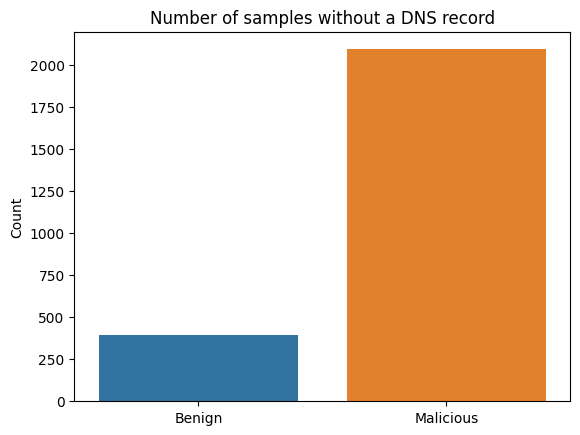

In [5]:
axes = sns.barplot(data=dataset.groupby('malicious')['has_dns_record'].sum().reset_index(), x='malicious', y='has_dns_record', hue='malicious', legend=False)
axes.set_title('Number of samples without a DNS record')
axes.set_xlabel('')
axes.set_ylabel('Count')
axes.set_xticklabels(['Benign', 'Malicious'])
plt.show()

As expected, the number of malicious URLs without a DNS record is higher than the benign URLs ones, but I expected to see more of the malicious URLs (they are roughly 2,000 over 30,000). This can be due to the fact that PhishTank gives only the most recent ones.

#### **6.1.2. TLD Distribution**

Another interesting thing to see is the distribution of TLDs among malicious and benign URLs. In order to plot that as a tag cloud plot (or cloud words plot) I decided to use a python package called `wordcloud`.

In [ ]:
%pip install wordcloud

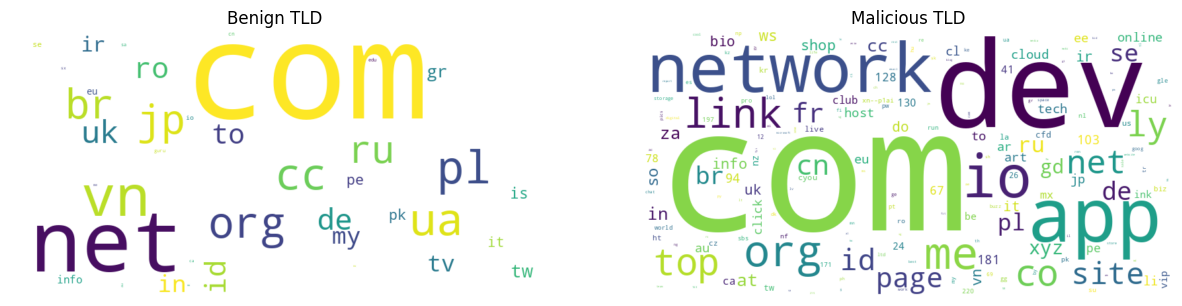

In [7]:
from wordcloud import WordCloud

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
benign_tld_count = dataset[dataset["malicious"] == 0]['tld'].str.split().explode().value_counts()
benign_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(benign_tld_count)
plt.imshow(benign_wordcloud, interpolation='bilinear')
plt.title('Benign TLD')
plt.axis('off')

plt.subplot(1, 2, 2)
malicious_tld_count = dataset[dataset["malicious"] == 1]['tld'].str.split().explode().value_counts()
malicious_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(malicious_tld_count)
plt.imshow(malicious_wordcloud, interpolation='bilinear')
plt.title('Malicious TLD')
plt.axis('off')

plt.show()

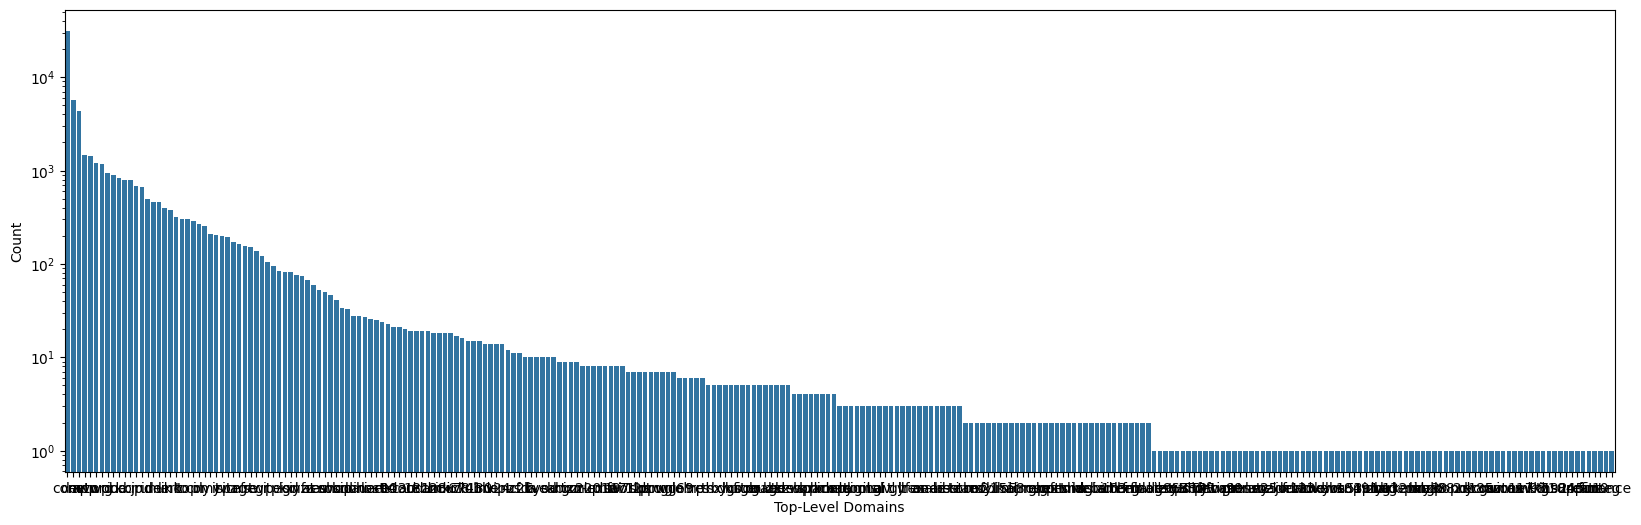

In [8]:
plt.figure(figsize=(20, 6))
axes = sns.countplot(dataset, x='tld', order=dataset['tld'].value_counts().index)
axes.set_yscale('log')
axes.set_xlabel('Top-Level Domains')
axes.set_ylabel('Count')
plt.show()

As expected, the most used TLDs for what concerns benign URLs are the usual ones such as `.com`, `.org`, `.net`, or the so called ccTLD (Country Code TLD), i.e. TLD codes that are specific to a State. On the other hand, the most used TLDs for what concerns malicious URLs, apart from the `.com`, are generic TLDs that are mostly used for small projects like `.dev`, `.app`, `.io`, `.me`, `.top`, `.site` and so on. But we can also see that in general most of the TLDs are rarely used. Maybe later it is the case to perform some cleaning.

#### **6.1.3. Web Traffic Distribution**

Another interesting thing to see is the distribution of page ranks.

/tmp/ipykernel_7474/1270806386.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(['Benign', 'Malicious'])


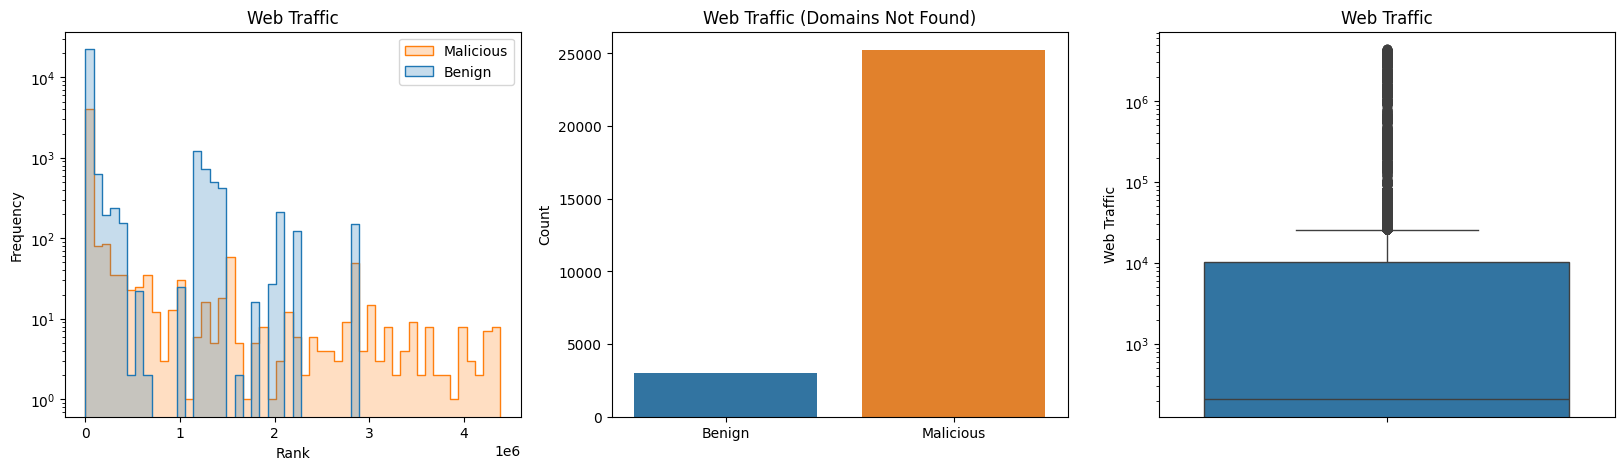

In [9]:
_, ax = plt.subplots(1, 3, figsize=(20, 5))

axes = sns.histplot(dataset[dataset['web_traffic'] > 0], x="web_traffic", hue="malicious", element="step", bins=50, ax=ax[0])
axes.set_yscale('log')
axes.set_title('Web Traffic')
axes.set_xlabel('Rank')
axes.set_ylabel('Frequency')
axes.legend(['Malicious', 'Benign'])

axes = sns.countplot(data=dataset[dataset['web_traffic'] == -1], x='malicious', hue="malicious", legend=False, ax=ax[1])
axes.set_title('Web Traffic (Domains Not Found)')
axes.set_xlabel('')
axes.set_ylabel('Count')
axes.set_xticklabels(['Benign', 'Malicious'])

axes = sns.boxplot(dataset, y='web_traffic', ax=ax[2])
axes.set_title('Web Traffic')
axes.set_ylabel('Web Traffic')
axes.set_yscale('log')

plt.show()


As we can see, while benign URLs uses domains for a large part the most popular domains. Malicious URLs instead, for the most part are not even ranked, otherwise they abuse the most popular domains.

#### **6.1.4. URL Length**

Another interesting thing to see is if and how much the length of the URL vary between benign and malicious URLs.

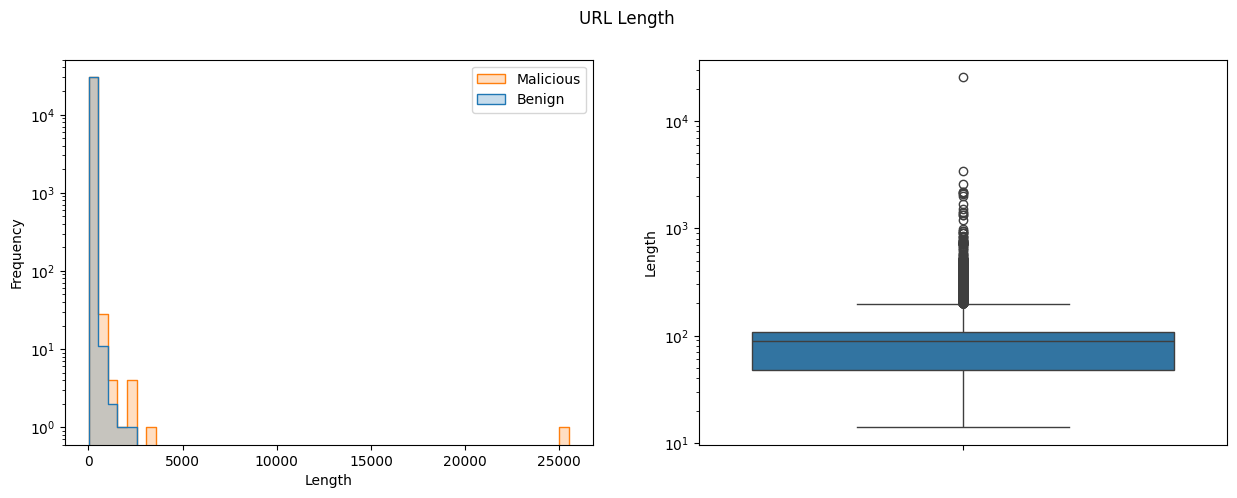

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

axes = sns.histplot(dataset, x="url_len", hue="malicious", element="step", bins=50, ax=ax1)
axes.set_yscale('log')
axes.set_xlabel('Length')
axes.set_ylabel('Frequency')
axes.legend(['Malicious', 'Benign'])

axes = sns.boxplot(dataset, y="url_len", ax=ax2)
axes.set_yscale('log')
axes.set_xlabel('')
axes.set_ylabel('Length')

fig.suptitle('URL Length')
plt.show()

Interestingly there is no big difference between the length of benign and malicious URLs. I was expecting to see malicious URLs significantly longer. However, in general there are a lot of outliers that has to be taken into account.

#### **6.1.5. Domain End Period**

It is also interesting to see also what happens with the domain end period.

/tmp/ipykernel_7474/499335723.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(['Benign', 'Malicious'])


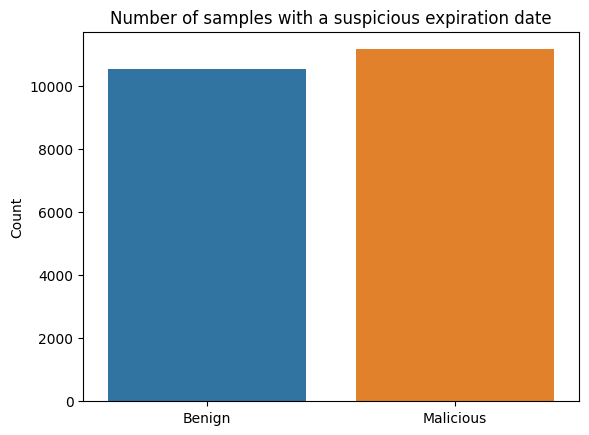

In [11]:
axes = sns.barplot(data=dataset.groupby('malicious')['sus_domain_end_period'].sum().reset_index(), x='malicious', y='sus_domain_end_period', hue='malicious', legend=False)
axes.set_title('Number of samples with a suspicious expiration date')
axes.set_xlabel('')
axes.set_ylabel('Count')
axes.set_xticklabels(['Benign', 'Malicious'])
plt.show()

Interestingly both have a high number of domains with an expiration date that is less than 6 months after the creation date.

#### **6.1.6. URL Entropy**

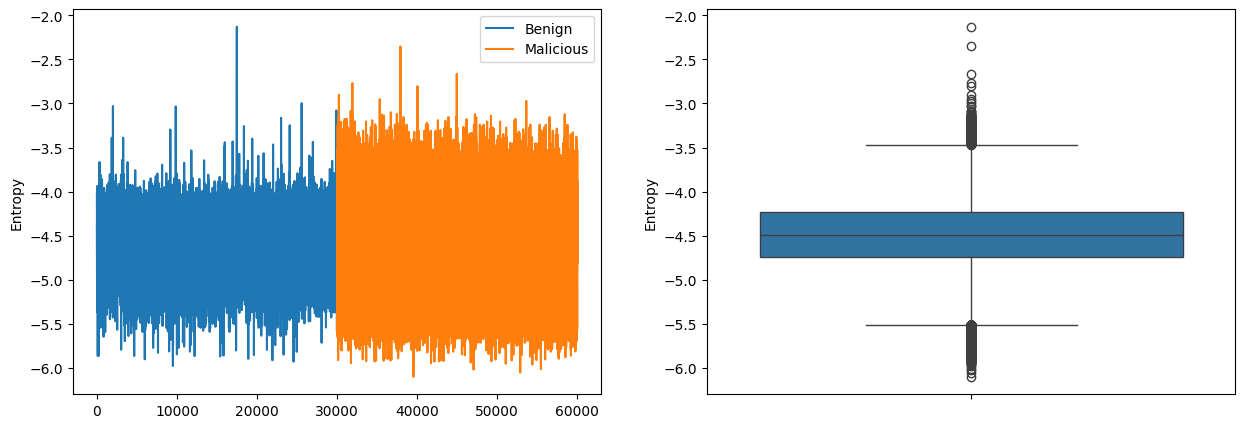

In [12]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

axes = sns.lineplot(dataset, x=dataset.index, y='entropy', hue='malicious', ax=ax1)
axes.set_xlabel('')
axes.set_ylabel('Entropy')
axes.legend(axes.get_legend_handles_labels()[0], ['Benign', 'Malicious'])

axes = sns.boxplot(dataset, y='entropy', ax=ax2)
axes.set_ylabel('Entropy')
plt.show()

As expected, in the majority of the cases malicious URLs have entropy values with a higher variance. Even in this feature there are a lot of outliers to deal with.

### **6.1.7. Other Features**

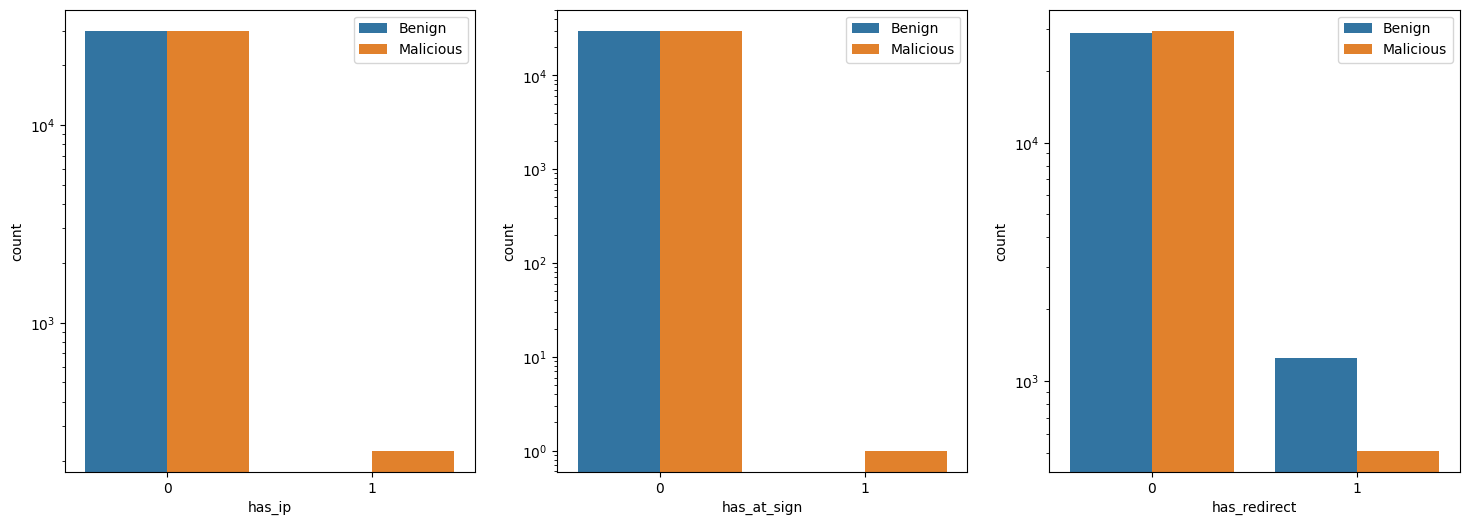

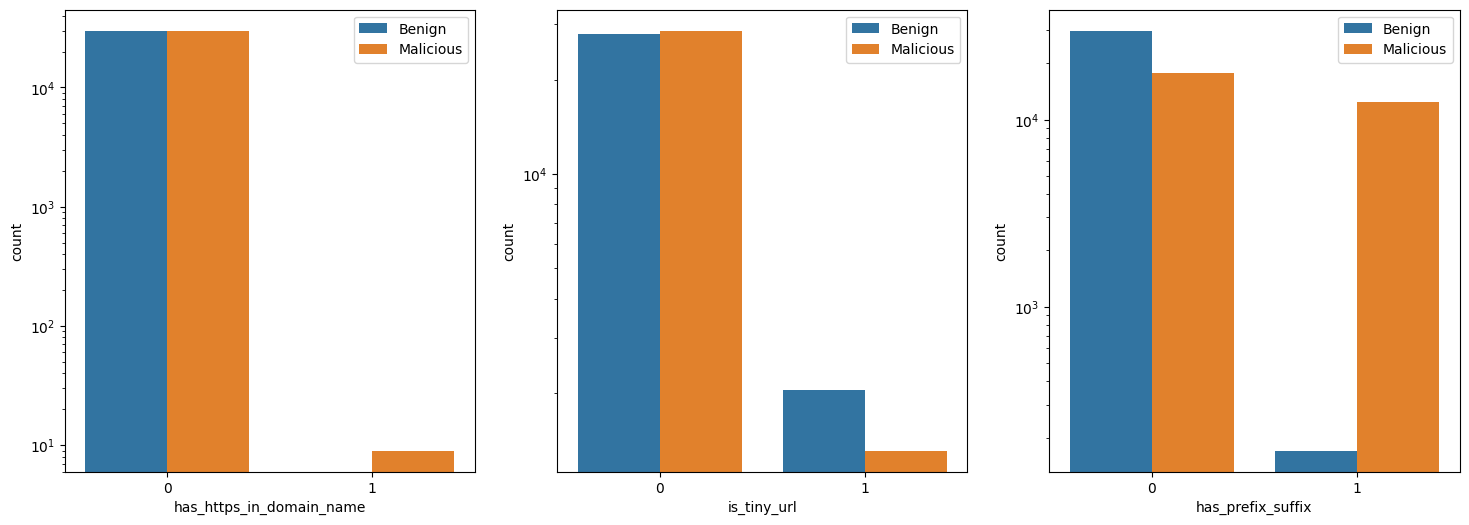

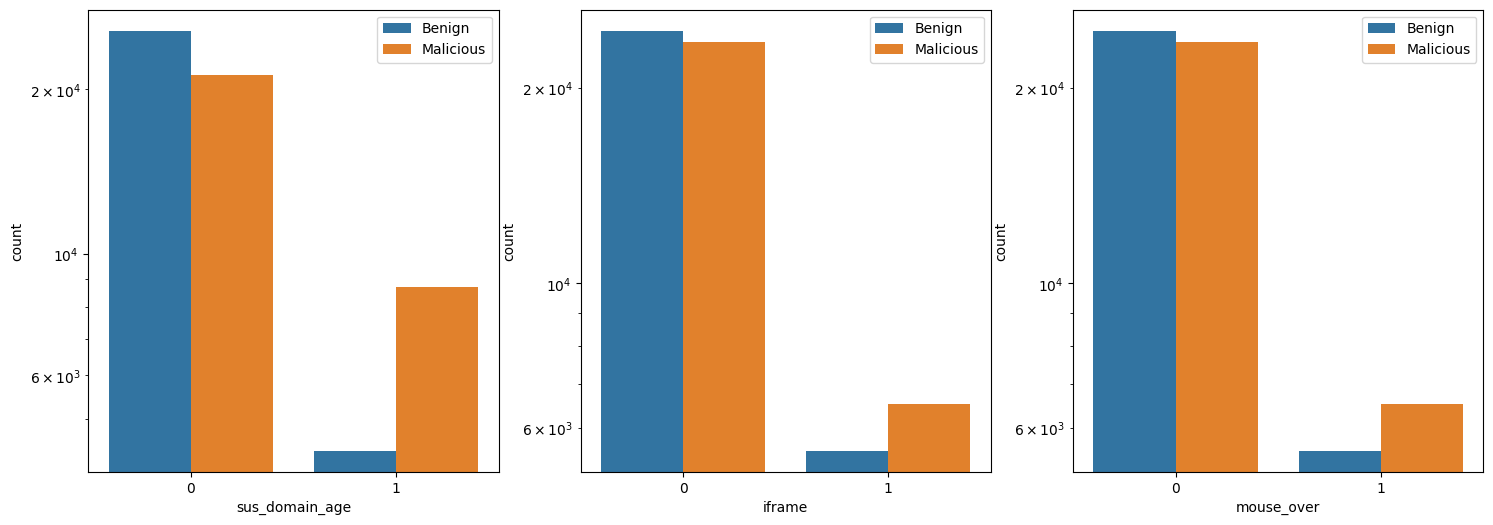

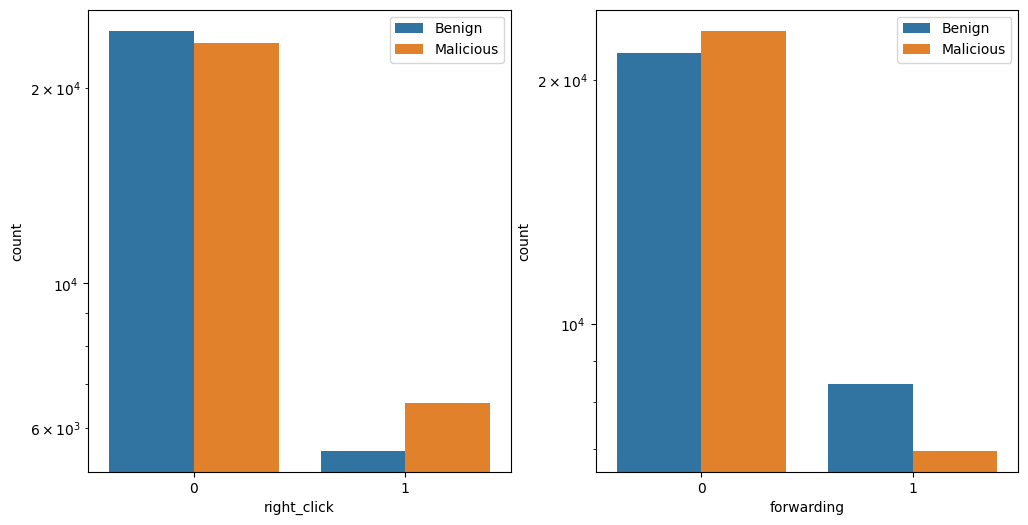

In [13]:
nominal_features = dataset.drop(columns=['has_dns_record', 'tld', 'web_traffic', 'url_len', 'sus_domain_end_period', 'entropy', 'url', 'domain_name', 'n_subdomains', 'url_depth', 'n_digits', 'n_params', 'malicious'], axis=1)
plots_per_line = 3
for i, column in enumerate(nominal_features.columns):
    if i % plots_per_line == 0:
        r = len(nominal_features.columns) - i
        if r < plots_per_line:
            n_plots = r
        else:
            n_plots = plots_per_line
        _, axs = plt.subplots(1, n_plots, figsize=(6*n_plots, 6))
        plot = 0
    axes = sns.countplot(dataset, x=column, hue='malicious', ax=axs[plot])
    axes.set_yscale('log')
    axes.legend(['Benign', 'Malicious'])
    if plot == n_plots-1:
        plt.show()
    plot+=1

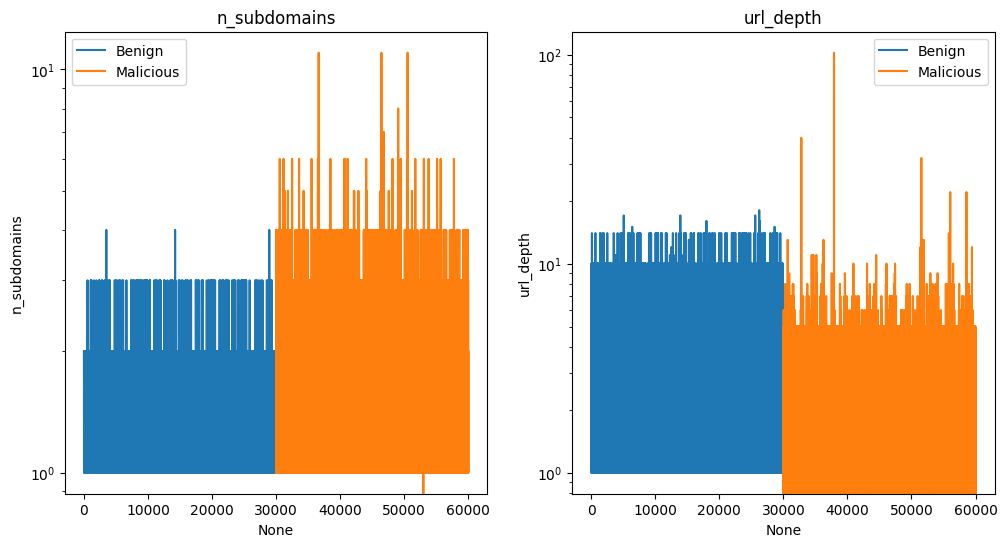

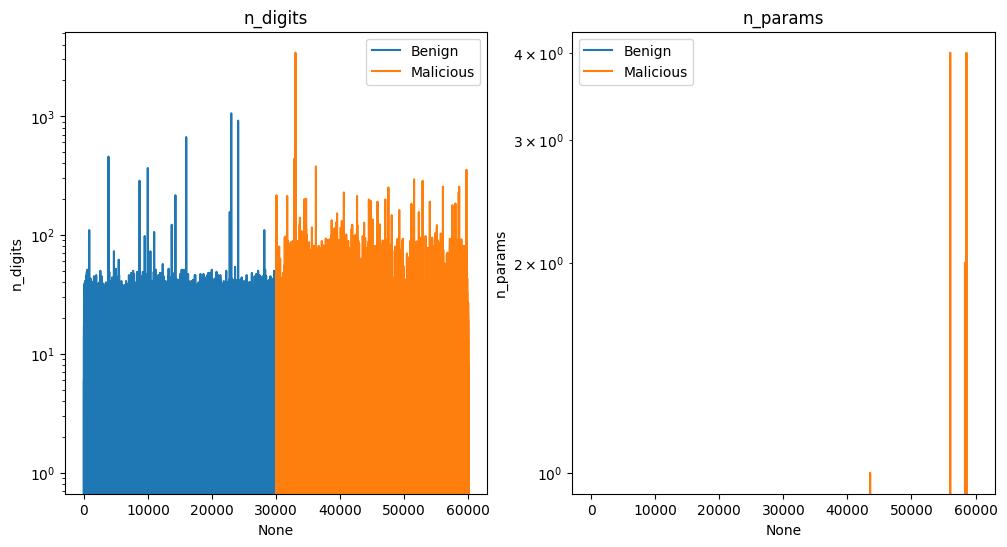

In [14]:

to_keep = ['n_subdomains', 'url_depth', 'n_digits', 'n_params']
other_features = dataset.drop(columns=[col for col in dataset.columns if col not in to_keep], axis=1)
plots_per_line = 2
for i, column in enumerate(other_features.columns):
    if i % plots_per_line == 0:
        r = len(other_features.columns) - i
        if r < plots_per_line:
            n_plots = r
        else:
            n_plots = plots_per_line
        _, axs = plt.subplots(1, n_plots, figsize=(6*n_plots, 6))
        plot = 0
    axes = sns.lineplot(dataset, x=dataset.index, y=column, hue='malicious', ax=axs[plot])
    axes.set_title(column)
    axes.set_yscale('log')
    axes.legend(axes.get_legend_handles_labels()[0], ['Benign', 'Malicious'])
    if plot == n_plots-1:
        plt.show()
    plot+=1

One thing to notice and that we have to take care of is that one record has 0 subdomains, which is not possible.

### **6.2. Null Values**

In [15]:
dataset.isnull().sum()

url                         0
domain_name                 0
has_ip                      0
has_at_sign                 0
url_len                     0
n_subdomains                0
url_depth                   0
has_redirect                0
has_https_in_domain_name    0
is_tiny_url                 0
has_prefix_suffix           0
entropy                     0
n_digits                    0
n_params                    0
tld                         2
has_dns_record              0
web_traffic                 0
sus_domain_age              0
sus_domain_end_period       0
iframe                      0
mouse_over                  0
right_click                 0
forwarding                  0
malicious                   0
dtype: int64

In [16]:
dataset[dataset['tld'].isnull()]

url  \
44143  http://lb.jieiq.chileinsumos.cl./#.aHR0cHM6Ly9...   
48814  http://j3.4z0vc.chileinsumos.cl./#.aHR0cHM6Ly9...   

                     domain_name  has_ip  has_at_sign  url_len  n_subdomains  \
44143  lb.jieiq.chileinsumos.cl.       0            0      127             4   
48814  j3.4z0vc.chileinsumos.cl.       0            0      139             4   

       url_depth  has_redirect  has_https_in_domain_name  is_tiny_url  ...  \
44143          1             0                         0            0  ...   
48814          1             0                         0            0  ...   

       tld  has_dns_record  web_traffic  sus_domain_age sus_domain_end_period  \
44143  NaN               0           -1               1                     1   
48814  NaN               0           -1               1                     1   

       iframe  mouse_over  right_click  forwarding  malicious  
44143       1           1            1           1          1  
48814       1           1            1           1          1  

[2 rows x 24 columns]

There are 2 malicious URLs that have the `tld` feature set to `NaN`. If we take a look at the values of `url`, we can see that they are malformed URLs since they don't have a TLD, but somehow they passed the validation step. Later in the [Data Cleaning](#7-data-cleaning) section we can safely remove them since there are only 2 instances of them over 60,000 samples and their removal won't affect the balance of the dataset.

### **6.3. Duplicates**

In [17]:
dataset[dataset.duplicated()]

url  \
40232  https://storage.cloud.google.com/1lordman1man3...   
42277  https://storage.cloud.google.com/1lordman1man3...   

                    domain_name  has_ip  has_at_sign  url_len  n_subdomains  \
40232  storage.cloud.google.com       0            0       82             3   
42277  storage.cloud.google.com       0            0       82             3   

       url_depth  has_redirect  has_https_in_domain_name  is_tiny_url  ...  \
40232          2             0                         0            0  ...   
42277          2             0                         0            0  ...   

       tld  has_dns_record  web_traffic  sus_domain_age sus_domain_end_period  \
40232  com               0           -1               0                     0   
42277  com               0           -1               0                     0   

       iframe  mouse_over  right_click  forwarding  malicious  
40232       0           0            0           1          1  
42277       0           0            0           1          1  

[2 rows x 24 columns]

There is one malicious URL that is duplicated. For the goals we are trying to achieve, duplicated samples are not useful so later we can safely discard the duplicate.

## **7. Data Cleaning**

### **7.1. Null Values Handling**

As seen before, there are 2 samples with null values, but as we said before we can discard them.

In [18]:
dataset = dataset.dropna().reset_index(drop=True)
dataset.isnull().sum()

url                         0
domain_name                 0
has_ip                      0
has_at_sign                 0
url_len                     0
n_subdomains                0
url_depth                   0
has_redirect                0
has_https_in_domain_name    0
is_tiny_url                 0
has_prefix_suffix           0
entropy                     0
n_digits                    0
n_params                    0
tld                         0
has_dns_record              0
web_traffic                 0
sus_domain_age              0
sus_domain_end_period       0
iframe                      0
mouse_over                  0
right_click                 0
forwarding                  0
malicious                   0
dtype: int64

### **7.2. Duplicates Handling**

As seen before, there is 1 sample that is duplicated, but as we said before we can discard it.

In [19]:
dataset = dataset.drop_duplicates().reset_index(drop=True)
dataset[dataset.duplicated()]

Empty DataFrame
Columns: [url, domain_name, has_ip, has_at_sign, url_len, n_subdomains, url_depth, has_redirect, has_https_in_domain_name, is_tiny_url, has_prefix_suffix, entropy, n_digits, n_params, tld, has_dns_record, web_traffic, sus_domain_age, sus_domain_end_period, iframe, mouse_over, right_click, forwarding, malicious]
Index: []

[0 rows x 24 columns]

### **7.3. Web Traffic Cleaning**

For what concernes the `web_traffic` feature, it should be an ordinal attribute. However, the fact that the domain names whose rank is not found have a value of -1 together with the fact that most popular URLs have a lower rank (thus a rank nearer to -1), doesn't play well with the fact that it is an ordinal feature. To solve this problem, I decided to invert the rank, i.e. assign a higher rank value to the most popular domains, and assign zero to the domains whose rank is not found, which means that they are the less popular ones.

In [20]:
from tranco import Tranco

t = Tranco(cache=True)
n_ranks = len(t.list(full=True).list)
dataset['web_traffic'] = dataset['web_traffic'].apply(lambda r: n_ranks-r+1 if r != -1 else 0)

Let's re-visualize the data after the trasformation.

/tmp/ipykernel_7474/4151708443.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(['Benign', 'Malicious'])


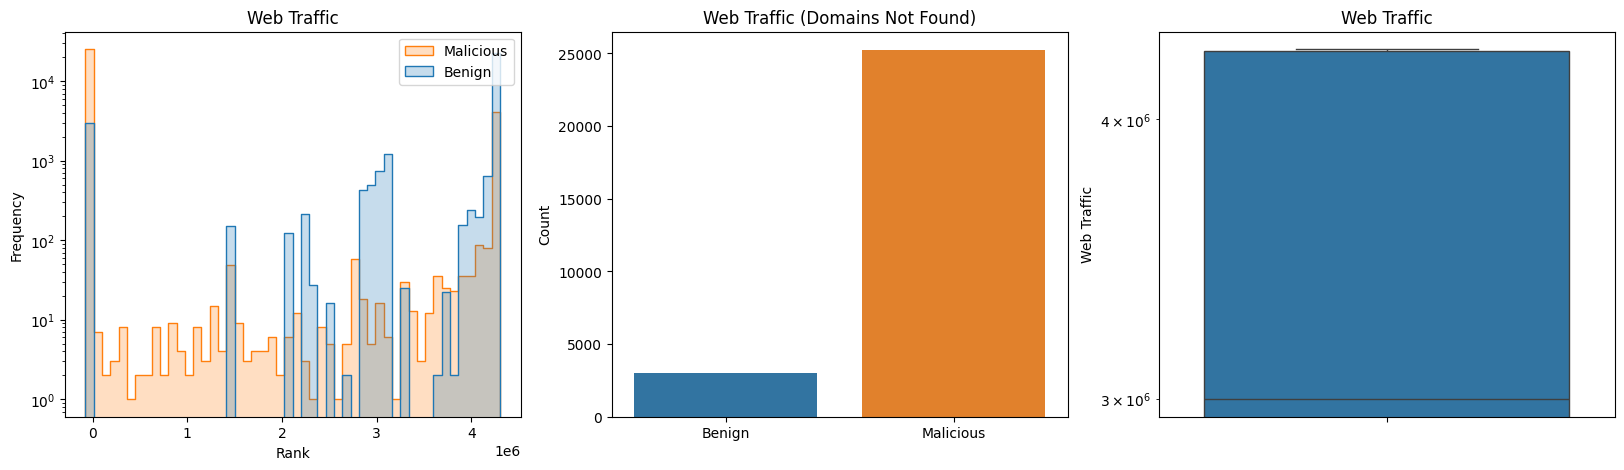

In [21]:
_, ax = plt.subplots(1, 3, figsize=(20, 5))

axes = sns.histplot(dataset, x="web_traffic", hue="malicious", element="step", bins=50, ax=ax[0])
axes.set_yscale('log')
axes.set_title('Web Traffic')
axes.set_xlabel('Rank')
axes.set_ylabel('Frequency')
axes.legend(['Malicious', 'Benign'])

axes = sns.countplot(data=dataset[dataset['web_traffic'] == 0], x='malicious', hue="malicious", legend=False, ax=ax[1])
axes.set_title('Web Traffic (Domains Not Found)')
axes.set_xlabel('')
axes.set_ylabel('Count')
axes.set_xticklabels(['Benign', 'Malicious'])

axes = sns.boxplot(dataset, y='web_traffic', ax=ax[2])
axes.set_title('Web Traffic')
axes.set_ylabel('Web Traffic')
axes.set_yscale('log')

plt.show()

### **7.4. TLD Cleaning**

In [22]:
dataset['tld'].unique().shape[0]

271

There are 271 different TLDs in our dataset, and as we said before, a lot of them rarely appears. This is a table that shows the percentage of the top 20 TLD used:

In [23]:
top_tlds = dataset['tld'].value_counts().head(20)
percentage_values = (top_tlds / dataset['tld'].count()) * 100
percentage_table = pd.DataFrame({'Value': top_tlds.index, 'Count': top_tlds.values, 'Percentage': percentage_values.values})
percentage_table = percentage_table.sort_values(by='Count', ascending=False)
percentage_table.reset_index(drop=True, inplace=True)
percentage_table

Value  Count  Percentage
0       com  31397   52.331822
1       dev   5640    9.400627
2       net   4335    7.225482
3       app   1465    2.441829
4        vn   1418    2.363491
5   network   1202    2.003467
6       org   1170    1.950130
7        pl    951    1.585106
8        io    895    1.491766
9        ua    822    1.370091
10       cc    801    1.335089
11       br    795    1.325088
12       jp    681    1.135076
13       ru    661    1.101740
14       id    494    0.823388
15       de    466    0.776718
16       me    463    0.771718
17       uk    400    0.666711
18     link    379    0.631709
19       ro    319    0.531702

As we can see, the 20-th row represent a TLD that appears only 319 times over 60,000 samples (it make up the 0.5% of the dataset). And we have also to take into account the fact that there are also other TLDs that are not present in this dataset (in total there are 1449 different TLDs [[10](#reference-section-10)]). To deal with this last situation, and to reduce the total number of possible values, I decided to create a new label `others` and replace all the values of the samples whose TLD is not in the top 20 with that value.

In [24]:
dataset['tld'] = dataset['tld'].apply(lambda x: x if x in top_tlds.index else 'others')
dataset[dataset['tld'].str.startswith('others')].shape[0]

5242

Now let's visualize again the data after the trasformation.

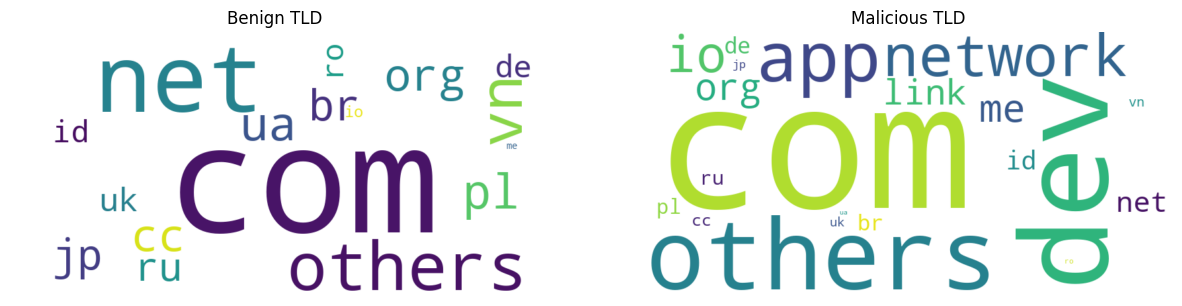

In [25]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
benign_tld_count = dataset[dataset["malicious"] == 0]['tld'].str.split().explode().value_counts()
benign_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(benign_tld_count)
plt.imshow(benign_wordcloud, interpolation='bilinear')
plt.title('Benign TLD')
plt.axis('off')

plt.subplot(1, 2, 2)
malicious_tld_count = dataset[dataset["malicious"] == 1]['tld'].str.split().explode().value_counts()
malicious_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(malicious_tld_count)
plt.imshow(malicious_wordcloud, interpolation='bilinear')
plt.title('Malicious TLD')
plt.axis('off')

plt.show()

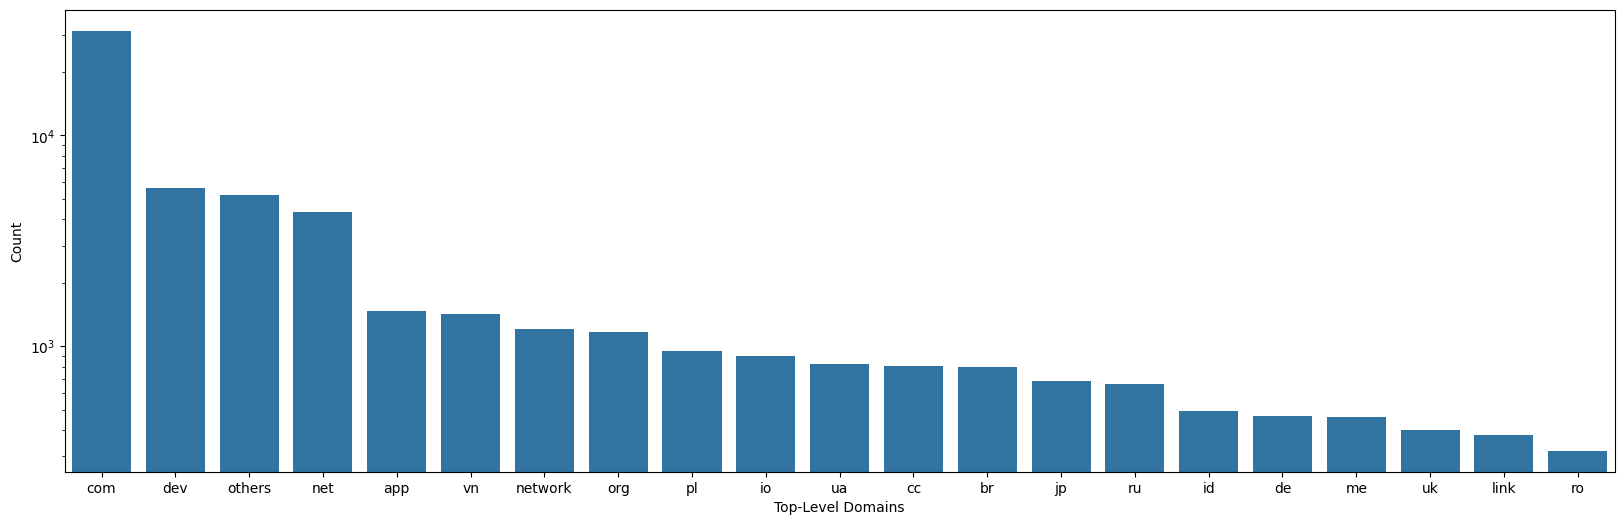

In [26]:
plt.figure(figsize=(20, 6))
axes = sns.countplot(dataset, x='tld', order=dataset['tld'].value_counts().index)
axes.set_yscale('log')
axes.set_xlabel('Top-Level Domains')
axes.set_ylabel('Count')
plt.show()

Now the least used 5242 TLDs, together with future unseen TLDs, are all marked with the `others` label.

### **7.5. TLD Encoding**

Since the `tld` feature is a nominal feature, we have also to encode it. After the cleaning performed in the previous section, now its possible values are:

In [27]:
dataset['tld'].unique().shape[0]

21

Since now the total number of possible labels is 21, which are not that much, we can apply a One-Hot Encoding to encode the `tld` feature.

In [28]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
raw_new_data = ohe.fit_transform(dataset[['tld']]).astype(int).toarray()
new_feature_names = ohe.get_feature_names_out(['tld'])

encoded_data = pd.DataFrame(raw_new_data, columns=new_feature_names)

encoded_data.reset_index(drop=True, inplace=True)
dataset.reset_index(drop=True, inplace=True)

dataset = pd.concat([dataset.drop(columns=['tld']), encoded_data], axis=1)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59996 entries, 0 to 59995
Data columns (total 44 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   url                       59996 non-null  object 
 1   domain_name               59996 non-null  object 
 2   has_ip                    59996 non-null  int64  
 3   has_at_sign               59996 non-null  int64  
 4   url_len                   59996 non-null  int64  
 5   n_subdomains              59996 non-null  int64  
 6   url_depth                 59996 non-null  int64  
 7   has_redirect              59996 non-null  int64  
 8   has_https_in_domain_name  59996 non-null  int64  
 9   is_tiny_url               59996 non-null  int64  
 10  has_prefix_suffix         59996 non-null  int64  
 11  entropy                   59996 non-null  float64
 12  n_digits                  59996 non-null  int64  
 13  n_params                  59996 non-null  int64  
 14  has_dn

### **7.6. Handling of Strange Samples**

When I talk about strange samples I'm referring to the sample where the number of subdomains is 0. Let's see the complete sample.

In [29]:
dataset[dataset['n_subdomains'] == 0]

url domain_name  has_ip  \
52984  http://HTTPS://MYDELIVERY-EXPRESS.COM/DHL/       HTTPS       0   

       has_at_sign  url_len  n_subdomains  url_depth  has_redirect  \
52984            0       42             0          4             1   

       has_https_in_domain_name  is_tiny_url  ...  tld_net  tld_network  \
52984                         0            0  ...        0            0   

       tld_org  tld_others  tld_pl  tld_ro  tld_ru  tld_ua  tld_uk  tld_vn  
52984        0           1       0       0       0       0       0       0  

[1 rows x 44 columns]

This of course is not a valid URL, so we can discard it.

In [30]:
dataset = dataset.drop(index=dataset[dataset['n_subdomains'] == 0].index, axis=0).reset_index(drop=True)

### **7.7. Removing Unneeded Features**

There is one feature that I think it can be safely removed: `domain_name`. This will be always different, thus will not be useful in the detection of malicious URLs as a feature. So I decided to remove it.

In [31]:
dataset = dataset.drop(columns=['domain_name'])

And obviously, we have to remove the `url` feature since now it is represented by all the others.

In [32]:
dataset = dataset.drop(columns=['url'])

### **7.8. Outliers Handling**

From the plots above we can see that there are a lot of outliers in more that one features (for instance in the `url_len` or in the `entropy` features). But since I will use a Decision Tree as model to be applied, on which outliers doesn't penalize its performance, I decided to keep them. Other than that, maybe they can also help to recognize better some edge cases.

## **8. Data Preprocessing**

Before going on, we have to split the dataset into training and test set. To do that, I decided to use the following approach:
1. Since I have a lot of samples I will initially split the dataset into training set and test set using a simple Holdout method, where the training set will be 80% of the dataset, and the test set will be 20% of the dataset. Doing this will leave us with a test set that has 12,000 samples, which is still a lot.
2. I will use the training set to perform feature selection and to decide which features can be removed.
3. Then, I will split again the training set to get the pruning set, which will be 20% of the original training set.
4. Finally, I will submit the test set to the final classifier to check that the results of the metrics and all the techniques that I will use are still valid for completely unseen data.

Said that, let's split the dataset the first time. As said above, the test set will be 20% of the whole dataset, so I set `test_size=0.20`.

> **Note**: I also decided to shuffle the dataset before splitting it (`random_state=666`), this because when I created the final dataset csv file, I concatenated the malicious URL samples all after the benign URL samples. Since I don't know how `train_test_split` will select the samples to put in the test set, I decided to shuffle the whole dataset to avoid the case in which it pops out the samples in order. 

In [33]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(
    dataset.drop(['malicious'], axis=1), dataset['malicious'],
    test_size=0.20,  
    random_state=666)

print(train_x.shape)
print(test_x.shape)

(47996, 41)
(11999, 41)


### **8.1. Feature Selection**

First of all, let's compute and plot the correlation matrix to see if there are features that we can discard.

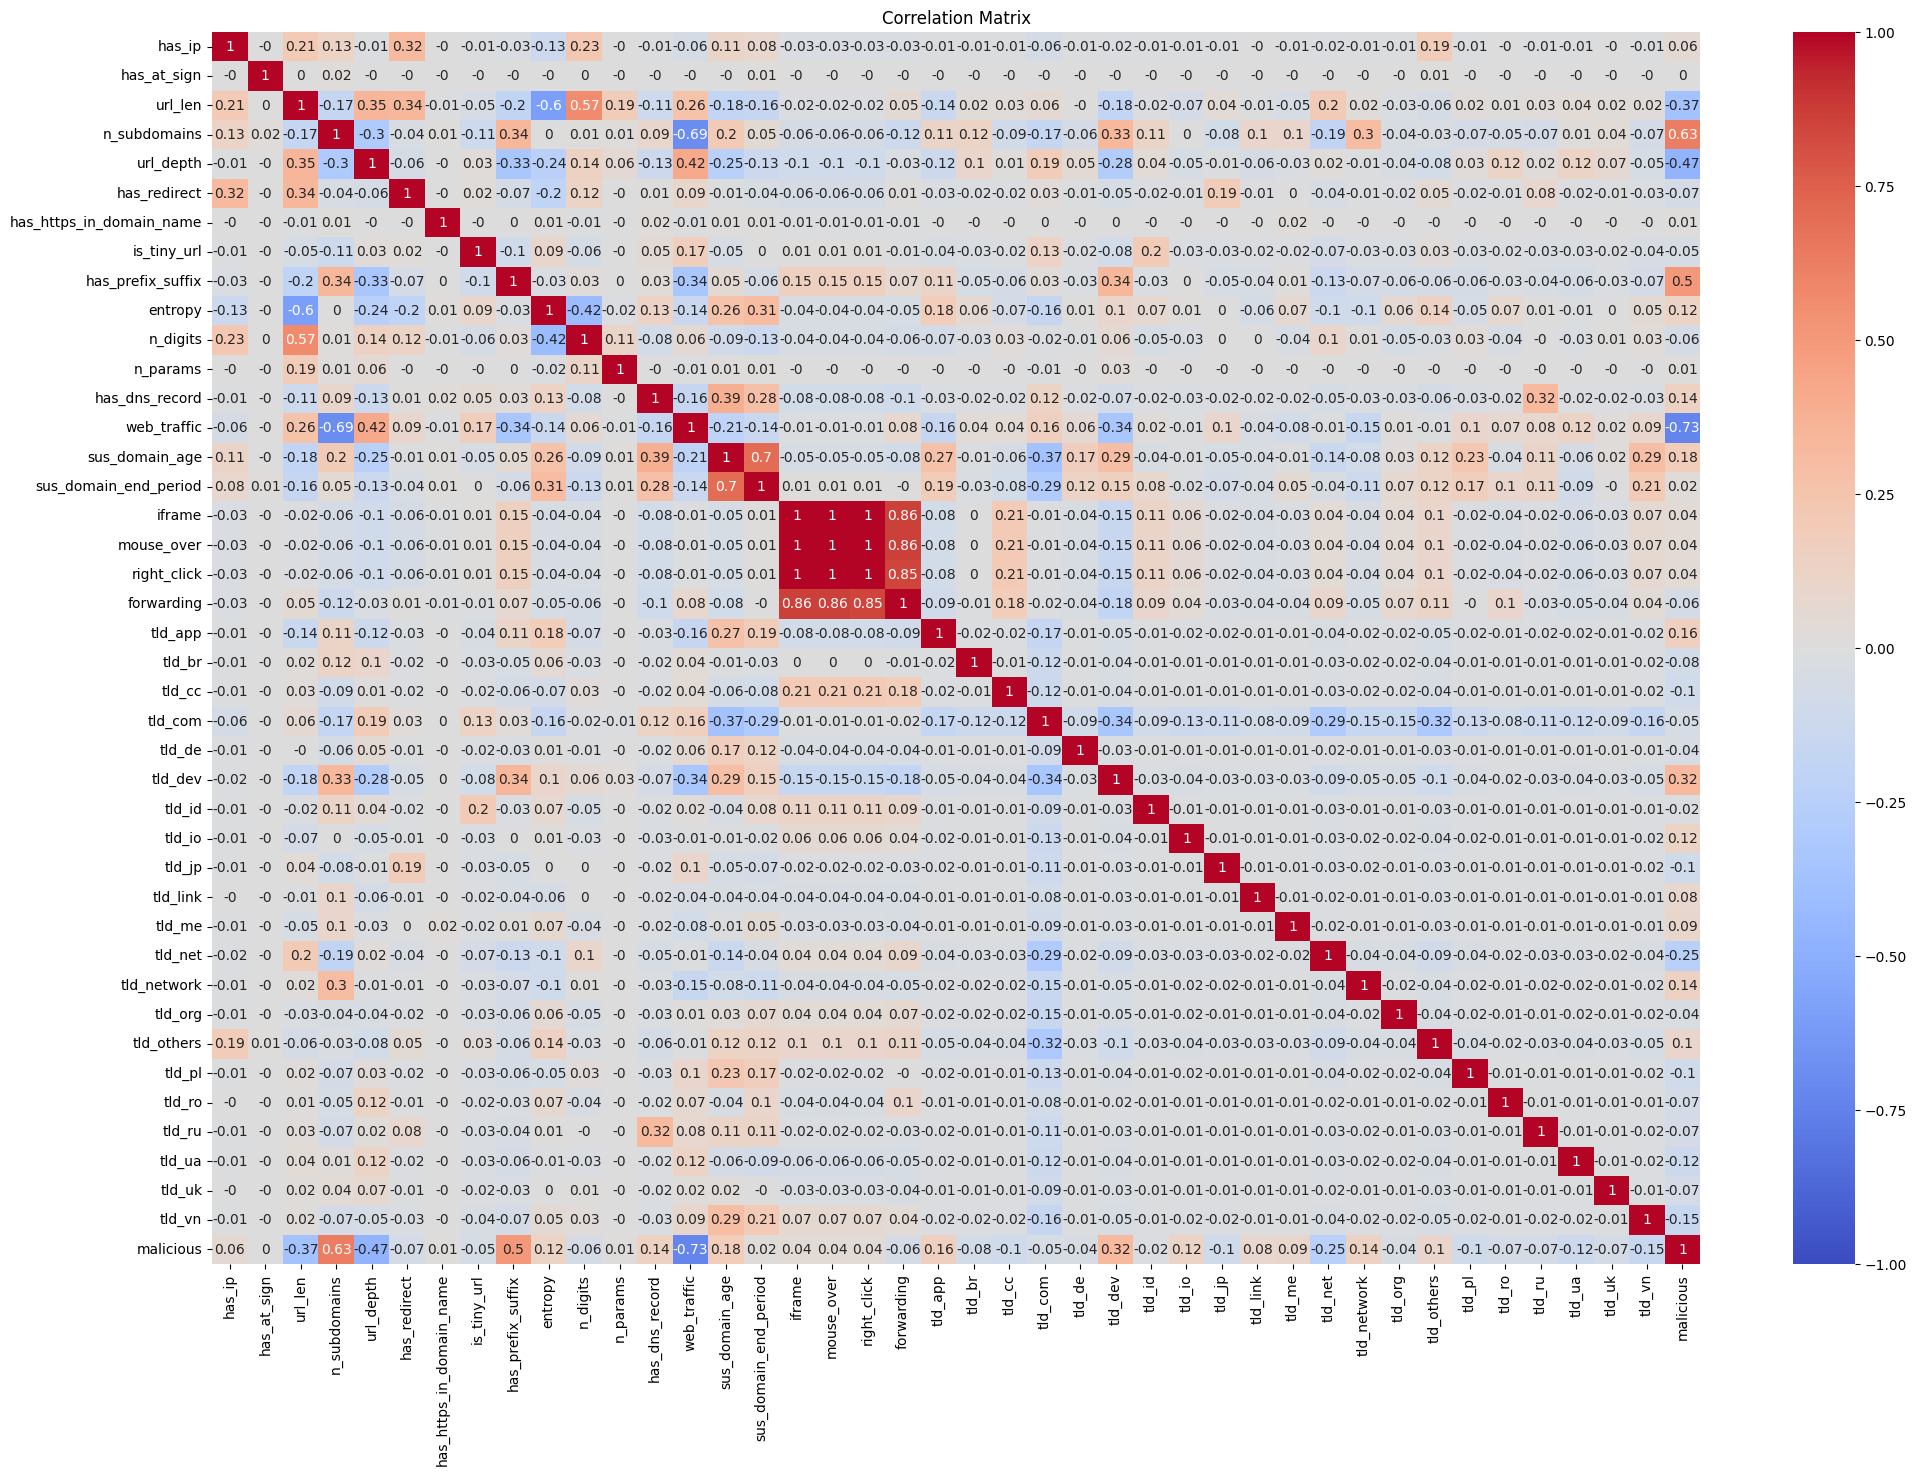

In [34]:
train_full_ds = pd.concat([train_x, train_y], axis=1)
corr_matrix = train_full_ds.corr(method='pearson').round(2)
plt.figure(figsize=(24, 16))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

From here we can see that:
1. The features `iframe`, `mouse_over`, `right_click`, and `forwarding` are all highly correlated.
2. The `sus_domain_end_period` and `sus_domain_age` features are highly correlated.
3. The `web_traffic` feature is inversely correlated with `n_subdomains`.
4. There is a feature that is completely uncorrelated with the target variable: `has_at_sign`.
5. There are a lot of features poorly correlated with the target variable (`has_ip`, `has_redirect`, `has_https_in_domain_name`, `is_tiny_url`, `n_digits`, `n_params`, `tld_br`, `tld_com`, `tld_de`, `tld_id`, `tld_link`, `tld_me`, `tld_org`, `tld_ro`, `tld_ru`, `tld_uk`).

#### **8.1.1. IFrame vs Mouse Over vs Right Click vs Forwarding**

These 4 variables, other than being highly correlated between themselves, are all also poorly correlated with the target feature `malicious`. Since for the previous table I used the Pearson's Coefficent, now I will use the Chi Square Test to see which is, between `iframe` `mouse_over` `right_click` and `forwarding`, the highly correlated with the target feature.

In [35]:
from scipy.stats import chi2_contingency

records = {}
candidates = ['iframe', 'mouse_over', 'right_click', 'forwarding']
for c in candidates:
    contingency_table = pd.crosstab(train_full_ds[c], train_full_ds['malicious'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    records[c] = (chi2, p, dof, expected)
    print(f"Feature {c}: Chi-Square={chi2}, P-Value={p}, Degrees-Of-Freedom={dof}")

Feature iframe: Chi-Square=76.91530216982788, P-Value=1.7844910297383307e-18, Degrees-Of-Freedom=1
Feature mouse_over: Chi-Square=76.91530216982788, P-Value=1.7844910297383307e-18, Degrees-Of-Freedom=1
Feature right_click: Chi-Square=79.63345203948089, P-Value=4.507291896904047e-19, Degrees-Of-Freedom=1
Feature forwarding: Chi-Square=162.3528032923973, P-Value=3.4642709907990973e-37, Degrees-Of-Freedom=1


From the results above, we can see that the feature `forwarding` is the most correlated to the target variable w.r.t. the others, but it is still quite low. So I decided to discard all of them.

In [36]:
train_selected = train_full_ds.drop(columns=['iframe', 'mouse_over', 'right_click', 'forwarding'])
removed_features = ['iframe', 'mouse_over', 'right_click', 'forwarding']

#### **8.1.2. Suspicious Domain End Period vs Suspicious Domain Age**

Since again both features are poorly correlated with the `malicious` feature from the table above, let's apply the same approach of the previous case.

In [37]:
records = {}
candidates = ['sus_domain_end_period', 'sus_domain_age']
for c in candidates:
    contingency_table = pd.crosstab(train_full_ds[c], train_full_ds['malicious'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    records[c] = (chi2, p, dof, expected)
    print(f"Feature {c}: Chi-Square={chi2}, P-Value={p}, Degrees-Of-Freedom={dof}")

Feature sus_domain_end_period: Chi-Square=23.622428427442635, P-Value=1.1721334076535119e-06, Degrees-Of-Freedom=1
Feature sus_domain_age: Chi-Square=1500.3886546359104, P-Value=0.0, Degrees-Of-Freedom=1


In this case, `sus_domain_age` is highly correlated with the target feature, instead even for the Chi-Square Test the `sus_domain_end_period` feature is poorly correlated with the target feature. Thus, I will keep `sus_domain_age`.

In [38]:
train_selected.drop(columns=['sus_domain_end_period'], inplace=True)
removed_features.append('sus_domain_end_period')

#### **8.1.3. Web Traffic vs Number of Subdomains**

For what concerns this case, from the matrix above we can see that both variables are also (positively or negatively) correlated with the target feature. Since their correlation is $|corr|<0.7$ I decide to keep both of them.

#### **8.1.4. Has At Sign**

For what concerns the `has_at_sign` feature, since it is completely uncorrelated with the target variable, I decide to discard it.

In [39]:
train_selected.drop(columns=['has_at_sign'], inplace=True)
removed_features.append('has_at_sign')

#### **8.1.5. Poorly Correlated Features**

Here we are speaking about those features that are poorly correlated with the target variable, but aren't completely uncorrelated like in the previous case. Since they have different values in the correlation matrix, I decided to proceed in this way:
- All the variables whose value in the matrix is $|corr| < 0.05$ will be completely discarded.
- All the others will be initially discarded, but after an initial training of the model, they will be singularly added to see if the model goes better with them. If some of them increases the performance of the model, they will be kept, otherwise they will be discarded.

In [40]:
to_discard = ['has_https_in_domain_name', 'n_params', 'tld_de', 'tld_id', 'tld_org']
train_selected.drop(columns=to_discard, inplace=True)
removed_features += to_discard

poorly_corr_feat = ['has_ip', 'has_redirect', 'is_tiny_url', 'n_digits', 'tld_br', 'tld_com', 'tld_link', 'tld_me', 'tld_ro', 'tld_ru', 'tld_uk']
train_selected.drop(columns=poorly_corr_feat, inplace=True)

### **8.2. Data Check**

After all those features have been removed, this is the situation.

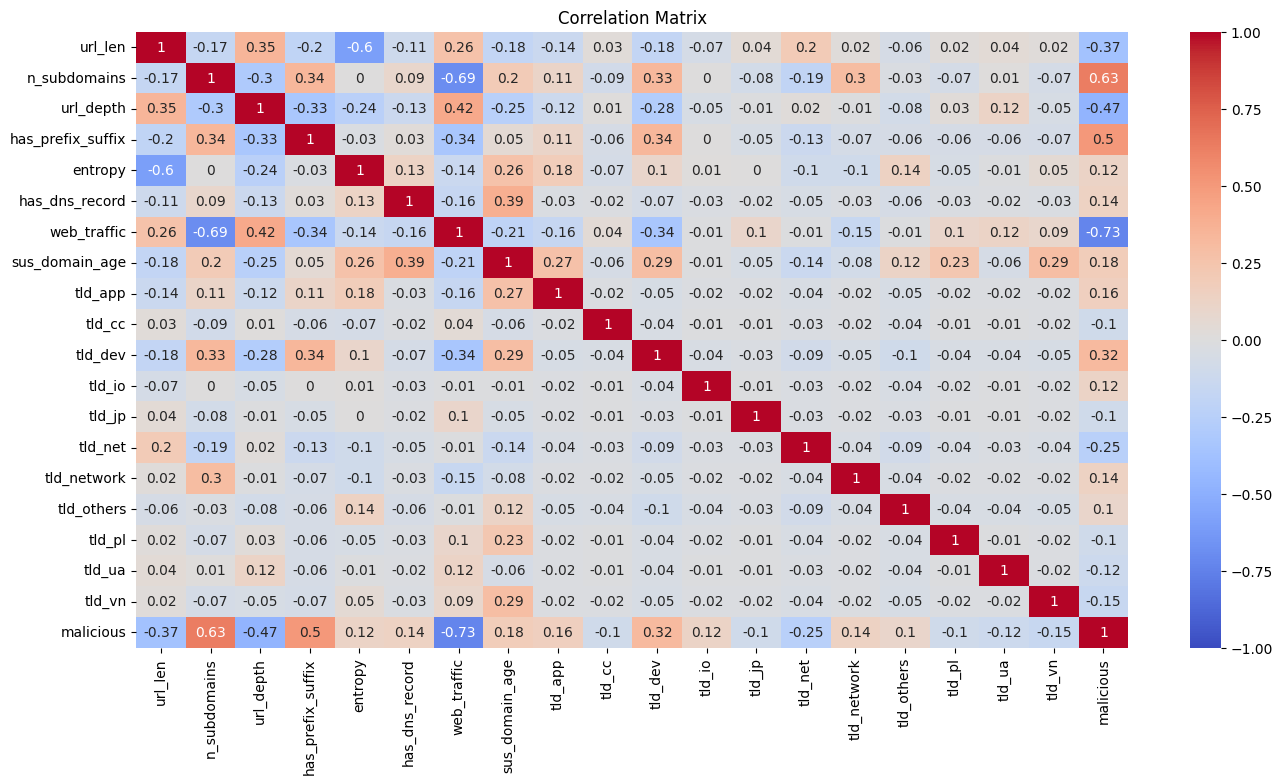

In [41]:
corr_matrix = train_selected.corr(method='pearson').round(2)
plt.figure(figsize=(16, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

### **8.3. Feature Normalization**

Since I will use a Decision Tree as model to be applied, which doesn't require values to be normalized and doesn't require data to fall between some specified ranges, I decided to not apply any normalization or transformation to the ordinal variables (`url_len`, `n_subdomains`, `entropy` and `web_traffic`) and to keep them as they are.

## **9. Processing**

As I was saying at the beginning of [Section 8](#8-data-preprocessing), I will split again the training set to obtain the pruning set.

In [42]:
train_x, prune_x, train_y, prune_y = train_test_split(
    train_selected.drop(['malicious'], axis=1), train_selected['malicious'],
    test_size=0.20,  
    random_state=666)

print(train_x.shape)
print(prune_x.shape)

(38396, 19)
(9600, 19)


Before going on, let's see if the new training set is still balanced.

In [43]:
train_y.value_counts()

malicious
1    19370
0    19026
Name: count, dtype: int64

Ok it is still quite balanced, so we can go on. Now I will apply what SciKit-Learn calls **Cost Complexity Pruning** [[11](#reference-section-11)], which is a Post-Pruning technique which has a parameter called *"Cost Complexity Parameter"* (`ccp_alpha`). This parameter defines the number of nodes to be pruned (the higher its value, the higher the number of nodes pruned). To get an idea of what values of `ccp_alpha` could be appropriate, SciKit-Learn provides a method that returns the values of `ccp_alpha` and the associated total leaf impurities at each step of the pruning process. 

In [44]:
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(random_state=666)
path = classifier.cost_complexity_pruning_path(train_x, train_y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Now let's see how these 2 values are correlated.

> **Note**: I will remove the last value in the series since it corresponds to the tree with only one node.

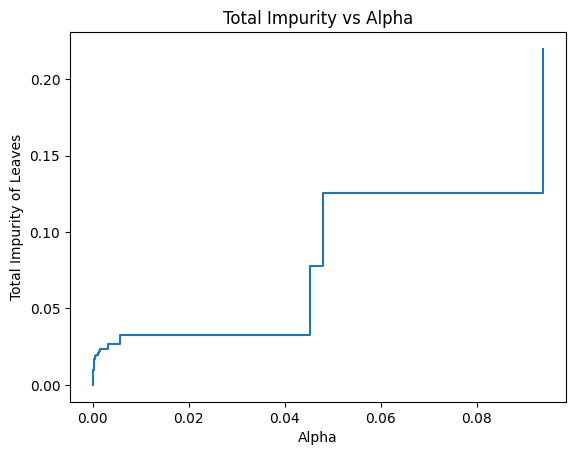

In [45]:
ccp_alphas = ccp_alphas[:-1]
impurities = impurities[:-1]

_, ax = plt.subplots()
ax.plot(ccp_alphas, impurities, drawstyle="steps-post")
ax.set_xlabel("Alpha")
ax.set_ylabel("Total Impurity of Leaves")
ax.set_title("Total Impurity vs Alpha")
plt.show()

As we can see, as `ccp_alpha` increases, more of the tree is pruned, which increases the total impurity of its leaves. Now, since I don't know with which value my decision tree will perform better, I will train one decision tree for each possible value of `ccp_alpha`, and then I will compare their performances using the pruning set I obtained before.

> **Note**: I will use the accuracy as metric because the training set is not imbalanced.

In [46]:
trees = []
for ccp_alpha in ccp_alphas:
    dec_tree = DecisionTreeClassifier(random_state=666, ccp_alpha=ccp_alpha)
    dec_tree.fit(train_x, train_y)
    trees.append(dec_tree)

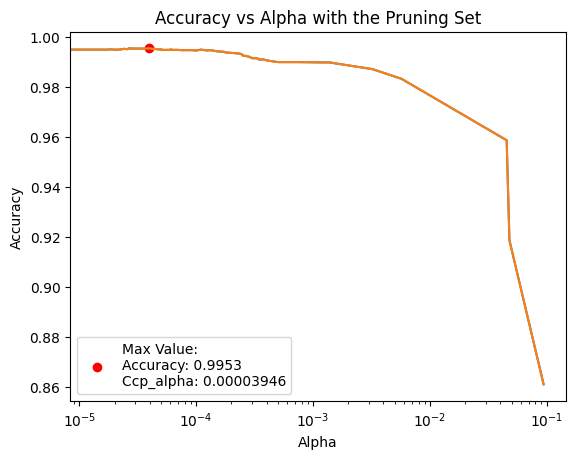

In [47]:
scores = [clf.score(prune_x, prune_y) for clf in trees]

max_score = max(scores)
max_index = len(scores) - scores[::-1].index(max_score) - 1
best_tree = trees[max_index]

ax = sns.lineplot(x=ccp_alphas, y=scores)
ax.set_xlabel("Alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs Alpha with the Pruning Set")
ax.plot(ccp_alphas, scores)
ax.set_xscale('log')

ax.scatter(ccp_alphas[max_index], max_score, color='red', label=f'Max Value:\nAccuracy: {max_score:.4f}\nCcp_alpha: {ccp_alphas[max_index]:.8f}')
ax.legend()

plt.show()

Since the bigger the value of `ccp_alpha` the more the tree is pruned and so the lower the number of nodes, in case there are multiple istances of trees with the top accuracy score, I will choose the one with a higher value for `ccp_alpha`. In this way the final decision tree will have less nodes, thus it will be (a little) faster.

## **10. Validation**

### **10.1. Direct Validation**

Now it's time to see how well our classifier performs on the test set. Here as metrics I will use also Precision, Recall and F1-Score other than the Accuracy to have a more complete view of the results.

              precision    recall  f1-score   support

      Benign     0.9953    0.9977    0.9965      6093
   Malicious     0.9976    0.9951    0.9964      5906

    accuracy                         0.9964     11999
   macro avg     0.9964    0.9964    0.9964     11999
weighted avg     0.9964    0.9964    0.9964     11999



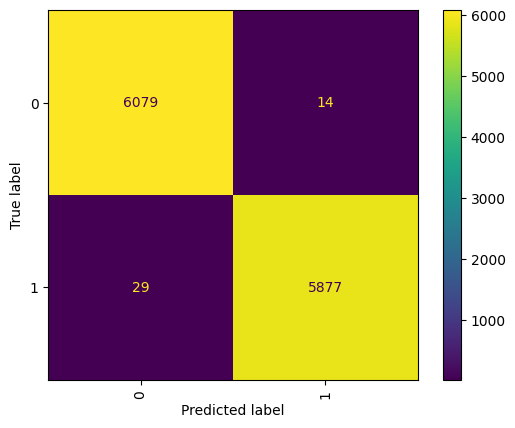

In [48]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

test_filtered_x = test_x.drop(columns=removed_features+poorly_corr_feat)
pred_y = best_tree.predict(test_filtered_x)

print(classification_report(test_y, pred_y, target_names=['Benign', 'Malicious'], digits=4))

ConfusionMatrixDisplay.from_estimator(best_tree, test_filtered_x, test_y, xticks_rotation="vertical")

I should have tested the process adding some of the features previously discarded that were poorly correlated with the target variable, but after having seen the results i doubt I can further improve the performances.

### **10.2. Check for further Feature Selection and Re-Validation**

From the final Decision Tree obtained, we can extract the importance of each feature in the decision process inside the classifier. Maybe there are some features that are completely unemployed and that can be discarded.

In [49]:
importances = pd.DataFrame(best_tree.feature_importances_, 
                           index=train_x.columns, columns=['Importance']).sort_values(by='Importance', ascending=False)

print(importances)

                   Importance
url_len              0.568966
web_traffic          0.198290
n_subdomains         0.098045
has_prefix_suffix    0.093484
url_depth            0.020318
entropy              0.018384
tld_io               0.000683
sus_domain_age       0.000602
tld_net              0.000445
tld_others           0.000346
has_dns_record       0.000251
tld_dev              0.000102
tld_pl               0.000085
tld_ua               0.000000
tld_cc               0.000000
tld_network          0.000000
tld_jp               0.000000
tld_app              0.000000
tld_vn               0.000000


We can see that there are some unused features that can be safely discarded: `tld_ua`, `tld_cc`, `tld_network`, `tld_jp`, `tld_app` and `tld_vn`. So I will discard them and redo the validation step. In doing that I expect that the removal of these features doesn't affect the performances, and we should obtain the same values as before.

              precision    recall  f1-score   support

      Benign     0.9953    0.9979    0.9966      6093
   Malicious     0.9978    0.9951    0.9964      5906

    accuracy                         0.9965     11999
   macro avg     0.9965    0.9965    0.9965     11999
weighted avg     0.9965    0.9965    0.9965     11999



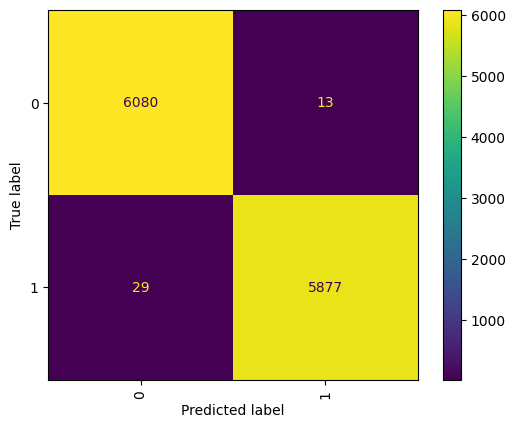

In [50]:
def train_classifier(train_x, train_y, prune_x, prune_y):
    classifier = DecisionTreeClassifier(random_state=666)
    path = classifier.cost_complexity_pruning_path(train_x, train_y)
    ccp_alphas = path.ccp_alphas[:-1]

    trees = []
    for ccp_alpha in ccp_alphas:
        dec_tree = DecisionTreeClassifier(random_state=666, ccp_alpha=ccp_alpha)
        dec_tree.fit(train_x, train_y)
        trees.append(dec_tree)

    scores = [clf.score(prune_x, prune_y) for clf in trees]

    max_score = max(scores)
    max_index = len(scores) - scores[::-1].index(max_score) - 1
    best_tree = trees[max_index]

    return best_tree

new_not_important_features = importances[importances['Importance'] == 0].index.to_list()

new_tree = train_classifier(train_x.drop(columns=new_not_important_features), 
                            train_y,
                            prune_x.drop(columns=new_not_important_features), 
                            prune_y)

tot_feat_to_remove = removed_features+poorly_corr_feat+new_not_important_features
test_filtered_x = test_x.drop(columns=tot_feat_to_remove)
pred_y = new_tree.predict(test_filtered_x)

print(classification_report(test_y, pred_y, target_names=['Benign', 'Malicious'], digits=4))

ConfusionMatrixDisplay.from_estimator(new_tree, test_filtered_x, test_y, xticks_rotation="vertical")

As we can see, at the end the results are almost the same, only new 1 sample has been misclassified. This can be due to the fact that one of the removed features maybe was not completely useless, but its level of importance has been set to zero due to an approximation (i.e. 0.0000001 is approximated to 0). Overall this is still fine and we can keep the final version.

## **11. Conclusions**

This is the final decision tree:

In [ ]:
%pip install graphviz pydotplus

> **Note**: to use `graphviz` you have to install it on your OS (for instance using `apt install graphviz`).

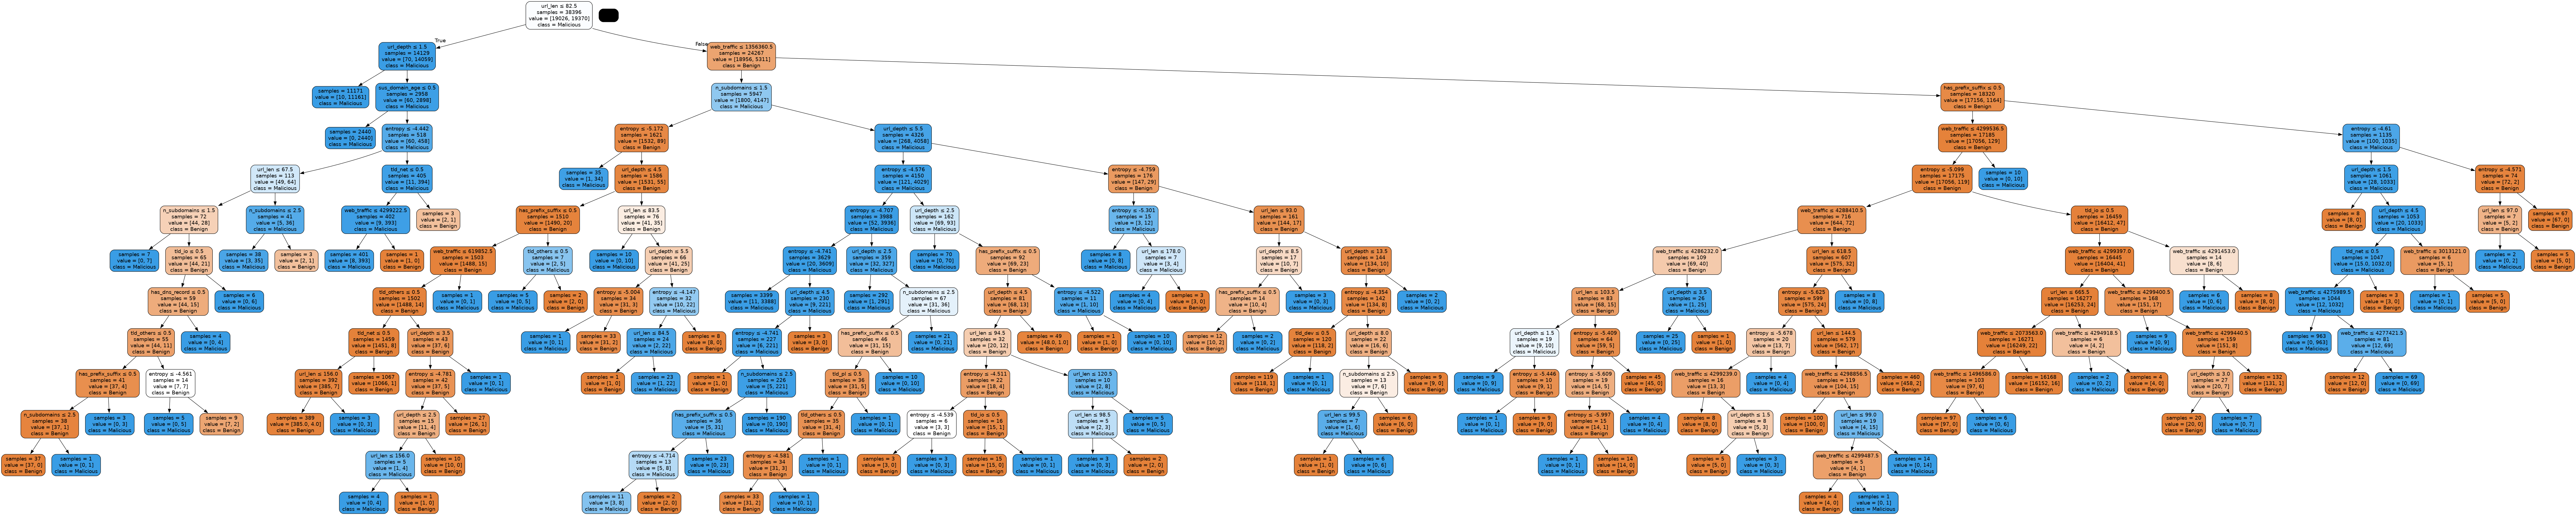

In [52]:
import pydotplus
from sklearn.tree import export_graphviz
from IPython.display import Image, display

dot_data = export_graphviz(
    new_tree,
    out_file=None,
    feature_names=test_filtered_x.columns,
    class_names=['Benign', 'Malicious'],
    filled=True,
    impurity=False,
    proportion=False,
    rounded=True,
    special_characters=True
)

graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_svg("decision_tree.svg")
display(Image(graph.create_png()))

And this is the final rule extracted from the tree that will decide if a URL is malicious:

In [53]:
import textwrap
import numpy as np
from sklearn.tree import _tree

def get_rules(tree, feature_names: list, target_class: int) -> list:
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    paths = []
    
    def recurse(node: int, depth: int, path: list):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            path_left = f"({name} <= {threshold})"
            path_right = f"({name} > {threshold})"
            recurse(tree_.children_left[node], depth + 1, path + [path_left])
            recurse(tree_.children_right[node], depth + 1, path + [path_right])
        else:
            if np.argmax(tree_.value[node]) == target_class:
                paths.append(path)

    recurse(0, 1, [])
    return paths

def boolean_expression(paths: list) -> str:
    return "("+(") OR (".join([" AND ".join(path) for path in paths]))+")"

rules = get_rules(new_tree, target_class=1, 
                  feature_names=test_filtered_x.columns)
expression = boolean_expression(rules)
wrapped_expression = textwrap.fill(expression, width=160)
print(wrapped_expression)

((url_len <= 82.5) AND (url_depth <= 1.5)) OR ((url_len <= 82.5) AND (url_depth > 1.5) AND (sus_domain_age <= 0.5)) OR ((url_len <= 82.5) AND (url_depth > 1.5)
AND (sus_domain_age > 0.5) AND (entropy <= -4.442240953445435) AND (url_len <= 67.5) AND (n_subdomains <= 1.5)) OR ((url_len <= 82.5) AND (url_depth > 1.5) AND
(sus_domain_age > 0.5) AND (entropy <= -4.442240953445435) AND (url_len <= 67.5) AND (n_subdomains > 1.5) AND (tld_io <= 0.5) AND (has_dns_record <= 0.5) AND
(tld_others <= 0.5) AND (has_prefix_suffix <= 0.5) AND (n_subdomains > 2.5)) OR ((url_len <= 82.5) AND (url_depth > 1.5) AND (sus_domain_age > 0.5) AND (entropy
<= -4.442240953445435) AND (url_len <= 67.5) AND (n_subdomains > 1.5) AND (tld_io <= 0.5) AND (has_dns_record <= 0.5) AND (tld_others <= 0.5) AND
(has_prefix_suffix > 0.5)) OR ((url_len <= 82.5) AND (url_depth > 1.5) AND (sus_domain_age > 0.5) AND (entropy <= -4.442240953445435) AND (url_len <= 67.5) AND
(n_subdomains > 1.5) AND (tld_io <= 0.5) AND (has_dns_r

These are the final features that are useful for the classification of malicious URLs:

In [54]:
test_filtered_x.columns.to_list()

['url_len',
 'n_subdomains',
 'url_depth',
 'has_prefix_suffix',
 'entropy',
 'has_dns_record',
 'web_traffic',
 'sus_domain_age',
 'tld_dev',
 'tld_io',
 'tld_net',
 'tld_others',
 'tld_pl']

At the end, a lot of variables that are listed in the literature, in particular the Address Bar Based features and the HTML & JavaScript Based features, are not so determinant in the distinction between malicious and benign URLs. And some of the non-classical features, such as `entropy` and `tld` are instead particularly useful in the classification.

It's also to notice that it is still necessary to actively interact with the content addressed by the malicious URL. And it is also to notice that, in order to detect those malicious URLs that are still alive and with a DNS record, it is important to use also other information other than the presence or absence of the DNS record itself (see `sus_domain_age`). So, all in all, I have made a good choice at the beginning when I decided to use fresh malicious URLs and not to rely on some old datasets (whose malicious URLs for sure wouldn't be still valid).

That being said, here I have experimented only some of the features proposed in the literature (the most common ones). Some future work could be:
- Try to better analyze data related to the domain age, creation date and end date inside a DNS record since here I have made some pre-assumption when building the dataset and I have extracted only binary features.
- Try to analyze other classical features.
- Try to analyze new features not present in the literature and see if some of them will be useful.

Since I will also build a small application, I will convert the Decision Tree into a Python function and save it into `./app/src/decision_tree.py`:

In [55]:
def tree_to_code(tree, feature_names: list) -> str:
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    code = f'def tree({", ".join(feature_names)}):\n'

    def recurse(node: int, depth: int) -> str:
        res = ''
        indent = " "*4 * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            res += f"{indent}if {name} <= {threshold}:\n"
            res += recurse(tree_.children_left[node], depth + 1)
            res += f"{indent}else:  # if {name} > {threshold}\n"
            res += recurse(tree_.children_right[node], depth + 1)
        else:
            class_idx = 0
            for idx, val in enumerate(tree_.value[node][0]):
                if val == 1:
                    class_idx = idx
                    break
            res += f"{indent}return {class_idx}\n"
        return res

    return code + recurse(0, 1)

code = tree_to_code(new_tree, test_filtered_x.columns)

with open('./app/src/decision_tree.py', "w") as f:
    f.write(code)

## **12. References**

1. [https://developer.mozilla.org/en-US/docs/Learn/Common_questions/Web_mechanics/What_is_a_URL#summary](https://developer.mozilla.org/en-US/docs/Learn/Common_questions/Web_mechanics/What_is_a_URL#summary)<div id="reference-section-1"></div>
2. [https://experteq.com/what-is-a-malicious-url-and-how-do-we-protect-against-them/](https://experteq.com/what-is-a-malicious-url-and-how-do-we-protect-against-them/)<div id="reference-section-2"></div>
3. [https://www.phishtank.com](https://www.phishtank.com)<div id="reference-section-3"></div>
4. [https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset/data](https://www.kaggle.com/datasets/sid321axn/malicious-urls-dataset/data)<div id="reference-section-4"></div>
5. [https://www.unb.ca/cic/datasets/url-2016.html](https://www.unb.ca/cic/datasets/url-2016.html)<div id="reference-section-5"></div>
6. [https://ijream.org/papers/IJREAMV07I0577009.pdf](https://ijream.org/papers/IJREAMV07I0577009.pdf)<div id="reference-section-6"></div>
7. [https://hsnarman.github.io/CONF/21-BLACKSEA-PhishingDetection.pdf](https://hsnarman.github.io/CONF/21-BLACKSEA-PhishingDetection.pdf)<div id="reference-section-7"></div>
8. [https://tranco-list.eu/](https://tranco-list.eu/)<div id="reference-section-8"></div>
9. [https://link.springer.com/article/10.1007/s40745-022-00379-8](https://link.springer.com/article/10.1007/s40745-022-00379-8)<div id="reference-section-9"></div>
10. [https://data.iana.org/TLD/tlds-alpha-by-domain.txt](https://data.iana.org/TLD/tlds-alpha-by-domain.txt)<div id="reference-section-10"></div>
11. [https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html)<div id="reference-section-11"></div>